# Setup

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.utils.class_weight import compute_sample_weight
import gc # Garbage collector para liberar RAM

In [2]:
# --- 1. CONFIGURACIÓN DE RUTAS LOCALES ---
# Usamos raw string (r'') para evitar líos con las barras de Windows
BASE_PATH = Path(r'C:/inteligencia_en_red') 

# Asegúrate de que tu archivo .parquet o .csv filtrado esté ahí
# Si no guardaste el parquet, carga el csv original y filtra de nuevo (avísame si necesitas código para eso)
DATA_FILE = BASE_PATH / 'dataset_completo.pkl'
# DATA_FILE = BASE_PATH / 'dataset_reducido_mrmulf_20.pkl'

# reducir datos

In [5]:
# --- 2. Reducir datos ---
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

df_reducido, _ = train_test_split(df, train_size=0.2, stratify=df[' mode'], random_state=42)

print(f"Tamaño reducido: {len(df_reducido)}")

Cargando datos desde: C:\proyecto_final_inteligencia\dataset_reducido_mrmulf.pkl
Dataset cargado. Shape: (172800, 4098)
Tamaño reducido: 34560


In [6]:
ruta_guardar_pickle = BASE_PATH / 'dataset_reducido_mrmulf_20.pkl'

print(f"Guardando DataFrame reducido en (formato Pickle): {ruta_guardar_pickle}")
df_reducido.to_pickle(ruta_guardar_pickle)
print("¡Guardado con éxito!")

Guardando DataFrame reducido en (formato Pickle): C:\proyecto_final_inteligencia\dataset_reducido_mrmulf_20.pkl
¡Guardado con éxito!


# Entrenamiento

In [ ]:
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)


In [6]:
# Preparar X e y
X = df.drop(' mode', axis = 1)
y_raw = df[' mode']

# Codificar etiquetas
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes_names = le.classes_
print(f"Clases: {classes_names}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Limpieza de RAM antes de entrenar
del df, X, y_raw, y
gc.collect()
print("Memoria limpiada. Iniciando configuración de XGBoost...")

Clases: ['am' 'dominoex11' 'fax' 'lsb' 'morse' 'mt63_1000' 'navtex'
 'olivia16_1000' 'olivia16_500' 'olivia32_1000' 'olivia8_250' 'psk31'
 'psk63' 'qpsk31' 'rtty100_850' 'rtty45_170' 'rtty50_170' 'usb']
Memoria limpiada. Iniciando configuración de XGBoost...


In [7]:
# --- 3. ENTRENAMIENTO ---
clf_xgb = XGBClassifier(
    n_estimators=2000,       # Damos más margen, pero...
    learning_rate=0.05,      # ...aprendemos más despacio
    
    # --- FRENOS DE COMPLEJIDAD ---
    max_depth=4,             # BAJAMOS de 6 a 4. Árboles menos profundos no pueden memorizar tanto ruido.
    min_child_weight=3,      # Necesita al menos 3 muestras para crear una hoja (evita aislar casos raros)
    
    # --- FRENOS DE ALEATORIEDAD ---
    subsample=0.7,           # Usa menos datos por árbol para variar más
    colsample_bytree=0.3,    # ¡RADICAL! Que mire solo el 30% de las 4000 columnas en cada árbol.
                             # Esto obliga al modelo a no depender de píxeles específicos.
    
    # --- FRENOS MATEMÁTICOS (REGULARIZACIÓN) ---
    gamma=1,                 # "Si la mejora no es mayor a 1, no dividas la rama". Esto poda el árbol.
    reg_alpha=5,             # Regularización L1: Elimina características inútiles (las pone a 0).
    reg_lambda=10,           # Regularización L2: Evita que una sola característica tenga demasiado peso.
    
    # --- CONFIG TÉCNICA ---
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # Mantén esto si usas GPU
    early_stopping_rounds=50
)

print("Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)")

clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)
[0]	validation_0-mlogloss:2.88442	validation_1-mlogloss:2.88511
[50]	validation_0-mlogloss:2.63004	validation_1-mlogloss:2.65947
[100]	validation_0-mlogloss:2.46834	validation_1-mlogloss:2.52668
[150]	validation_0-mlogloss:2.35301	validation_1-mlogloss:2.43997
[200]	validation_0-mlogloss:2.26239	validation_1-mlogloss:2.37762
[250]	validation_0-mlogloss:2.18552	validation_1-mlogloss:2.32867
[300]	validation_0-mlogloss:2.12056	validation_1-mlogloss:2.29153
[350]	validation_0-mlogloss:2.06164	validation_1-mlogloss:2.25999
[400]	validation_0-mlogloss:2.00763	validation_1-mlogloss:2.23280
[450]	validation_0-mlogloss:1.95836	validation_1-mlogloss:2.21045
[500]	validation_0-mlogloss:1.91253	validation_1-mlogloss:2.19096
[550]	validation_0-mlogloss:1.86986	validation_1-mlogloss:2.17421
[600]	validation_0-mlogloss:1.82894	validation_1-mlogloss:2.15874
[650]	validation_0-mlogloss:1.79041	validation_1-mlogloss:2.14517
[700]	v

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


Generando predicciones...


c:\inteligencia_en_red\env\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


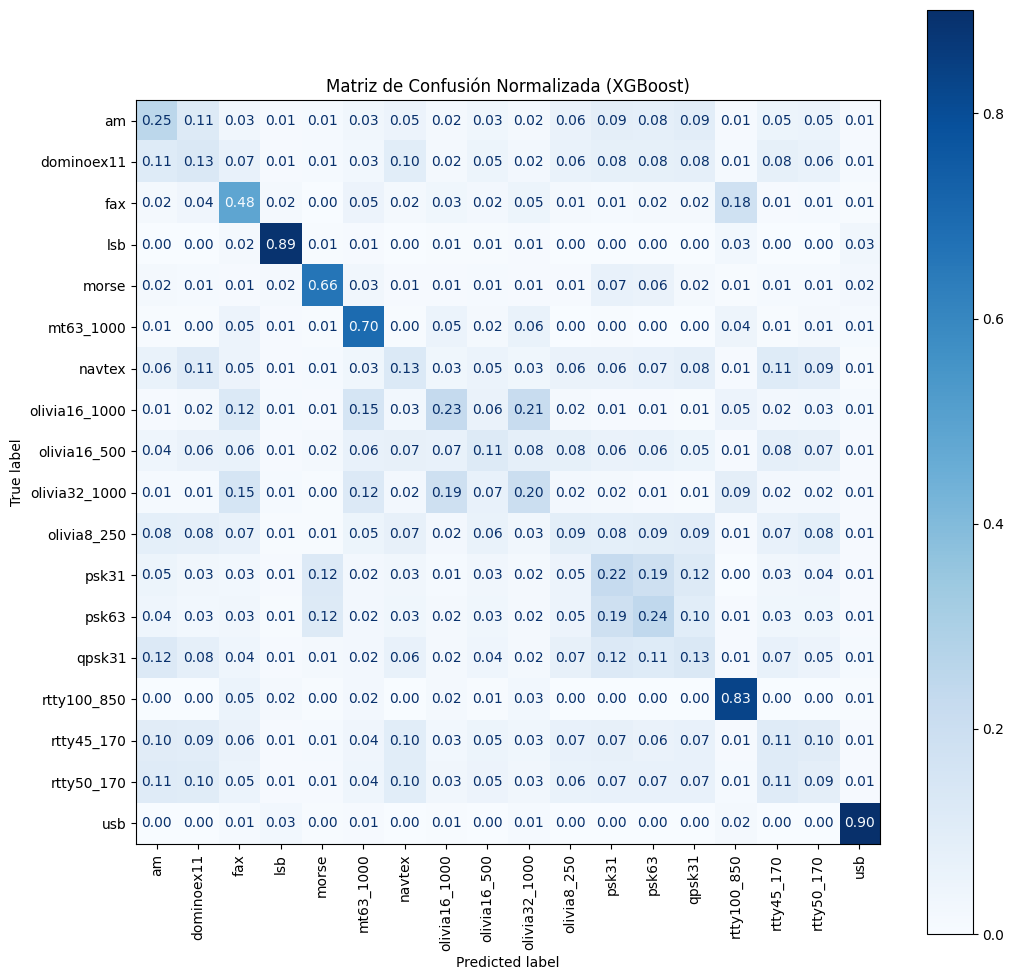


--- Reporte de Clasificación ---
               precision    recall  f1-score   support

           am       0.24      0.25      0.25      1920
   dominoex11       0.14      0.13      0.14      1920
          fax       0.35      0.48      0.40      1920
          lsb       0.82      0.89      0.85      1920
        morse       0.65      0.66      0.65      1920
    mt63_1000       0.48      0.70      0.57      1920
       navtex       0.15      0.13      0.14      1920
olivia16_1000       0.28      0.23      0.25      1920
 olivia16_500       0.16      0.11      0.13      1920
olivia32_1000       0.23      0.20      0.21      1920
  olivia8_250       0.13      0.09      0.11      1920
        psk31       0.19      0.22      0.21      1920
        psk63       0.21      0.24      0.23      1920
       qpsk31       0.14      0.13      0.14      1920
  rtty100_850       0.62      0.83      0.71      1920
   rtty45_170       0.13      0.11      0.12      1920
   rtty50_170       0.11      

In [8]:
# 1. Hacemos las predicciones sobre el conjunto de Test
print("Generando predicciones...")
y_pred_num = clf_xgb.predict(X_test)

# 2. TRADUCCIÓN: Convertimos los números predichos a nombres reales
# Usamos el 'le' (LabelEncoder) que creamos antes del entrenamiento
y_test_names = le.inverse_transform(y_test)
y_pred_names = le.inverse_transform(y_pred_num)

# 3. Pintamos la Matriz de Confusión
fig, ax = plt.subplots(figsize=(12, 12)) # Tamaño grande para que se lean las etiquetas

ConfusionMatrixDisplay.from_predictions(
    y_test_names,    # Etiquetas reales (Nombres)
    y_pred_names,    # Etiquetas predichas (Nombres)
    cmap='Blues',    # Mapa de color azul
    normalize='true', # ¡CLAVE! Muestra porcentajes (0 a 1) en vez de cantidades brutas
    xticks_rotation='vertical', # Pone los nombres de abajo en vertical
    values_format='.2f', # Muestra 2 decimales
    ax=ax
)

plt.title("Matriz de Confusión Normalizada (XGBoost)")
plt.show()

# 4. Imprimimos también el reporte detallado con la precisión exacta
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test_names, y_pred_names))

In [10]:
# --- 4. GUARDADO ---
save_dir = BASE_PATH / 'modelos'
save_dir.mkdir(parents=True, exist_ok=True)

paquete = {
    'modelo': clf_xgb,
    'encoder': le,
    'descripcion': 'XGBoost Local'
}

joblib.dump(paquete, save_dir / 'modelo_xgboost_local_todo.joblib')
print("¡Guardado!")

¡Guardado!


# Decisor Cat A y Cat B

In [31]:
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)


In [32]:
# Asumimos que 'df' es tu dataset cargado (con las 18 clases originales)

# 1. Definir quién es el "Equipo A" (Tus clases objetivo)
clases_grupo_A = [
    'fax', 
    'lsb', 
    'morse', 
    'mt63_1000', 
    'rtty100_850', 
    'usb'
]

# 2. Crear la columna binaria 'cat'
# Lógica: Si el modo está en la lista A -> pon un 0. Si no -> pon un 1.
# .str.strip() es vital por si quedaron espacios en blanco en los nombres
df['cat'] = df[' mode'].apply(lambda x: 1 if x.strip() in clases_grupo_A else 0)

# 3. Verificar el balance de clases
# Es probable que el grupo B (1) tenga el doble de datos que el A (0), 
# porque el grupo B tiene más modulaciones (todas las olivia, psk, etc.)
conteo = df['cat'].value_counts()
print("--- Distribución de Clases ---")
print(f"Categoría A (1): {conteo.get(0, 0)} muestras")
print(f"Categoría B (0): {conteo.get(1, 0)} muestras")

# 4. Eliminar la columna antigua 'mode' y preparar X e y
# Ya no necesitamos saber si es 'psk31' o 'psk63', solo que es 'clase 1'
X = df.drop(columns=[' mode', 'cat']) # Solo señales
y = df['cat'] # 0 o 1

--- Distribución de Clases ---
Categoría A (1): 115200 muestras
Categoría B (0): 57600 muestras


In [33]:
X.head

<bound method NDFrame.head of          snr  sample_real_0  sample_real_1  sample_real_2  sample_real_3  \
0         25      -0.968317      -0.853214      -0.713191      -0.561964   
1         25       0.007782       0.015447      -0.005821      -0.026951   
2         25       0.041998      -0.006114       0.016744      -0.010116   
3         25      -0.001029      -0.076369       0.055575      -0.022238   
4         25       0.938195       0.890012       0.822746       0.828651   
...      ...            ...            ...            ...            ...   
172795   -10      -0.621800       1.517429       1.338586      -1.095639   
172796   -10      -0.149647      -0.754459       1.049082       0.618660   
172797   -10       0.676589      -0.753482      -0.544221      -0.314956   
172798   -10      -1.129619       0.225984       0.653771      -0.817295   
172799   -10      -0.943027       0.045010      -0.242793       0.260704   

        sample_real_4  sample_real_5  sample_real_6  samp

In [7]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Limpieza de RAM antes de entrenar
del df, X, y
gc.collect()
print("Memoria limpiada. Iniciando configuración de XGBoost...")

Memoria limpiada. Iniciando configuración de XGBoost...


In [10]:
# --- 3. ENTRENAMIENTO ---

ratio = 2.5

clf_binary = XGBClassifier(
    # --- TUS PARÁMETROS ORIGINALES ---
    n_estimators=2000,
    learning_rate=0.05,
    
    # Frenos de complejidad (INTACTOS)
    max_depth=4,
    min_child_weight=3,
    
    # Frenos de aleatoriedad (INTACTOS)
    subsample=0.7,
    colsample_bytree=0.3,
    
    # Regularización matemática (INTACTA)
    gamma=1,
    reg_alpha=5,
    reg_lambda=10,
    
    # --- ÚNICO CAMBIO NECESARIO ---
    objective='binary:logistic', # Obligatorio para clasificación de 2 clases
    # ------------------------------
    
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # Asumo que sigues con GPU
    early_stopping_rounds=50,

    # Relación entre cat A y cat B
    scale_pos_weight=ratio
)

print("Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)")

clf_binary.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)
[0]	validation_0-logloss:0.73082	validation_1-logloss:0.73094
[50]	validation_0-logloss:0.57882	validation_1-logloss:0.58211
[100]	validation_0-logloss:0.50958	validation_1-logloss:0.51516
[150]	validation_0-logloss:0.46926	validation_1-logloss:0.47676
[200]	validation_0-logloss:0.44249	validation_1-logloss:0.45194
[250]	validation_0-logloss:0.42273	validation_1-logloss:0.43438
[300]	validation_0-logloss:0.40744	validation_1-logloss:0.42149
[350]	validation_0-logloss:0.39568	validation_1-logloss:0.41202
[400]	validation_0-logloss:0.38566	validation_1-logloss:0.40450
[450]	validation_0-logloss:0.37734	validation_1-logloss:0.39885
[500]	validation_0-logloss:0.37018	validation_1-logloss:0.39424
[550]	validation_0-logloss:0.36375	validation_1-logloss:0.39049
[600]	validation_0-logloss:0.35787	validation_1-logloss:0.38718
[650]	validation_0-logloss:0.35254	validation_1-logloss:0.38446
[700]	validation_0-logloss:0.34749	

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


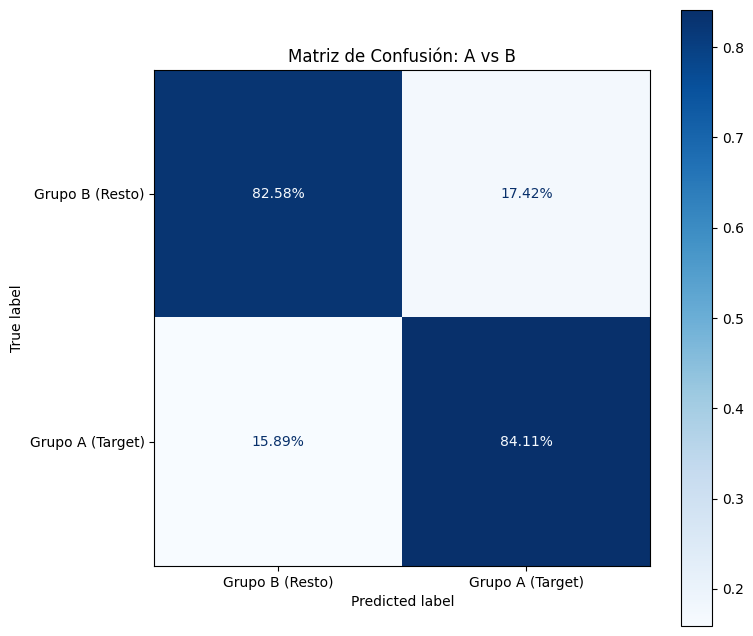


--- Reporte Detallado ---
                  precision    recall  f1-score   support

 Grupo B (Resto)       0.91      0.83      0.87     23040
Grupo A (Target)       0.71      0.84      0.77     11520

        accuracy                           0.83     34560
       macro avg       0.81      0.83      0.82     34560
    weighted avg       0.84      0.83      0.83     34560



In [11]:
# Predecir
y_pred = clf_binary.predict(X_test)

# Definir nombres para el gráfico
nombres = ['Grupo B (Resto)', 'Grupo A (Target)']

# Matriz
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=nombres,
    cmap='Blues', 
    normalize='true',
    values_format='.2%',
    ax=ax
)
plt.title("Matriz de Confusión: A vs B")
plt.show()

# Reporte numérico
print("\n--- Reporte Detallado ---")
print(classification_report(y_test, y_pred, target_names=nombres))

In [14]:
# --- 4. GUARDADO ---
save_dir = BASE_PATH / 'modelos'
save_dir.mkdir(parents=True, exist_ok=True)

paquete = {
    'modelo': clf_binary,
    'descripcion': 'XGBoost Local'
}

joblib.dump(paquete, save_dir / 'modelo_xgboost_local_categorias.joblib')
print("¡Guardado!")

¡Guardado!


# Decisor en Cat A

## Crear Dataset CatA

In [8]:
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)


In [9]:
# 1. Definir la Lista VIP (Categoría A)
clases_cat_A = [
    'fax', 
    'lsb', 
    'morse', 
    'mt63_1000', 
    'rtty100_850', 
    'usb'
]

print(f"Filtrando dataset para quedarse solo con: {clases_cat_A}")

# 2. Filtrar
# Usamos .str.strip() por seguridad, por si quedaron espacios ' usb' vs 'usb'
mask_A = df[' mode'].str.strip().isin(clases_cat_A)
df_A = df[mask_A].copy()

# 3. Resetear índice (Vital para que no explote luego el train_test_split)
df_A.reset_index(drop=True, inplace=True)

# 4. VERIFICACIÓN
print("-" * 30)
print(f"Tamaño Original: {df.shape}")
print(f"Tamaño Cat A:    {df_A.shape}")
print("-" * 30)
print("Clases encontradas en el nuevo DF:")
print(df_A[' mode'].unique())

# 5. LIMPIEZA DE RAM (Opcional pero recomendado)
# Si ya no vas a entrenar más el binario, borra el grande para liberar memoria
del df 
gc.collect()
print("Memoria liberada del dataset gigante.")

Filtrando dataset para quedarse solo con: ['fax', 'lsb', 'morse', 'mt63_1000', 'rtty100_850', 'usb']
------------------------------
Tamaño Original: (172800, 4098)
Tamaño Cat A:    (57600, 4098)
------------------------------
Clases encontradas en el nuevo DF:
['morse' 'rtty100_850' 'mt63_1000' 'usb' 'lsb' 'fax']
Memoria liberada del dataset gigante.


In [10]:
ruta_guardar_pickle = BASE_PATH / 'dataset_categoria_A.pkl'

print(f"Guardando DataFrame reducido en (formato Pickle): {ruta_guardar_pickle}")
df_A.to_pickle(ruta_guardar_pickle)
print("¡Guardado con éxito!")

Guardando DataFrame reducido en (formato Pickle): C:\inteligencia_en_red\dataset_categoria_A.pkl
¡Guardado con éxito!


## Entrenamiento

In [ ]:
DATA_FILE_A = BASE_PATH / 'dataset_categoria_A.pkl'

print(f"Cargando datos desde: {DATA_FILE_A}")

df_A = pd.read_pickle(DATA_FILE_A)
print(f"Dataset cargado. Shape: {df_A.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)


In [19]:
# Preparar X e y
X = df_A.drop(' mode', axis = 1)
y_raw = df_A[' mode']

# Codificar etiquetas
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes_names = le.classes_
print(f"Clases: {classes_names}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Limpieza de RAM antes de entrenar
del X, y_raw, y
gc.collect()
print("Memoria limpiada. Iniciando configuración de XGBoost...")

Clases: ['fax' 'lsb' 'morse' 'mt63_1000' 'rtty100_850' 'usb']
Memoria limpiada. Iniciando configuración de XGBoost...


In [20]:
# --- 3. ENTRENAMIENTO ---
clf_xgb = XGBClassifier(
    n_estimators=2000,       # Damos más margen, pero...
    learning_rate=0.05,      # ...aprendemos más despacio
    
    # --- FRENOS DE COMPLEJIDAD ---
    max_depth=4,             # BAJAMOS de 6 a 4. Árboles menos profundos no pueden memorizar tanto ruido.
    min_child_weight=3,      # Necesita al menos 3 muestras para crear una hoja (evita aislar casos raros)
    
    # --- FRENOS DE ALEATORIEDAD ---
    subsample=0.7,           # Usa menos datos por árbol para variar más
    colsample_bytree=0.3,    # ¡RADICAL! Que mire solo el 30% de las 4000 columnas en cada árbol.
                             # Esto obliga al modelo a no depender de píxeles específicos.
    
    # --- FRENOS MATEMÁTICOS (REGULARIZACIÓN) ---
    gamma=1,                 # "Si la mejora no es mayor a 1, no dividas la rama". Esto poda el árbol.
    reg_alpha=5,             # Regularización L1: Elimina características inútiles (las pone a 0).
    reg_lambda=10,           # Regularización L2: Evita que una sola característica tenga demasiado peso.
    
    # --- CONFIG TÉCNICA ---
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # Mantén esto si usas GPU
    early_stopping_rounds=50
)

print("Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)")

clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entrenando... (Abre el Administrador de Tareas para ver tu CPU al 100%)
[0]	validation_0-mlogloss:1.78294	validation_1-mlogloss:1.78358
[50]	validation_0-mlogloss:1.45233	validation_1-mlogloss:1.47452
[100]	validation_0-mlogloss:1.24625	validation_1-mlogloss:1.28662
[150]	validation_0-mlogloss:1.10575	validation_1-mlogloss:1.16298
[200]	validation_0-mlogloss:0.99992	validation_1-mlogloss:1.07255
[250]	validation_0-mlogloss:0.91653	validation_1-mlogloss:1.00350
[300]	validation_0-mlogloss:0.84870	validation_1-mlogloss:0.94916
[350]	validation_0-mlogloss:0.79247	validation_1-mlogloss:0.90610
[400]	validation_0-mlogloss:0.74463	validation_1-mlogloss:0.87127
[450]	validation_0-mlogloss:0.70299	validation_1-mlogloss:0.84293
[500]	validation_0-mlogloss:0.66599	validation_1-mlogloss:0.81845
[550]	validation_0-mlogloss:0.63239	validation_1-mlogloss:0.79722
[600]	validation_0-mlogloss:0.60180	validation_1-mlogloss:0.77911
[650]	validation_0-mlogloss:0.57415	validation_1-mlogloss:0.76358
[700]	v

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


Generando predicciones...


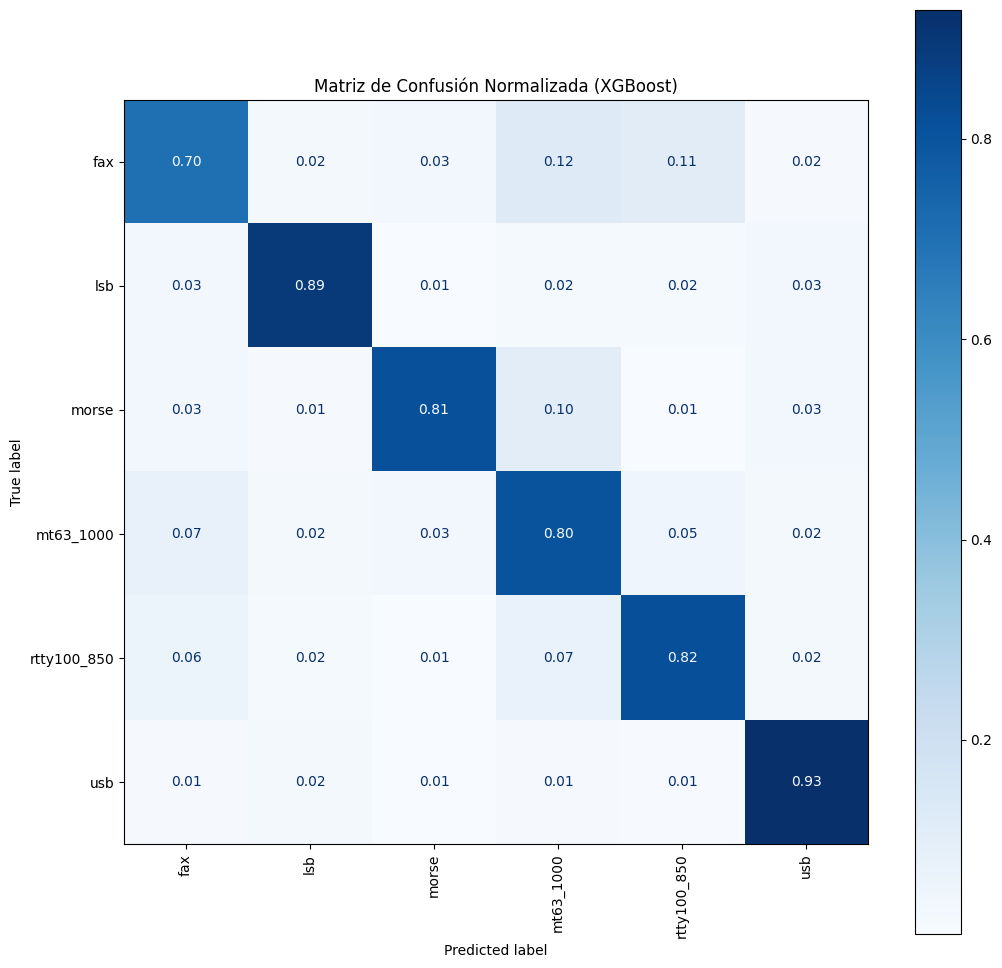


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

         fax       0.77      0.70      0.73      1920
         lsb       0.90      0.89      0.90      1920
       morse       0.91      0.81      0.86      1920
   mt63_1000       0.71      0.80      0.75      1920
 rtty100_850       0.81      0.82      0.81      1920
         usb       0.89      0.93      0.91      1920

    accuracy                           0.83     11520
   macro avg       0.83      0.83      0.83     11520
weighted avg       0.83      0.83      0.83     11520



In [21]:
# 1. Hacemos las predicciones sobre el conjunto de Test
print("Generando predicciones...")
y_pred_num = clf_xgb.predict(X_test)

# 2. TRADUCCIÓN: Convertimos los números predichos a nombres reales
# Usamos el 'le' (LabelEncoder) que creamos antes del entrenamiento
y_test_names = le.inverse_transform(y_test)
y_pred_names = le.inverse_transform(y_pred_num)

# 3. Pintamos la Matriz de Confusión
fig, ax = plt.subplots(figsize=(12, 12)) # Tamaño grande para que se lean las etiquetas

ConfusionMatrixDisplay.from_predictions(
    y_test_names,    # Etiquetas reales (Nombres)
    y_pred_names,    # Etiquetas predichas (Nombres)
    cmap='Blues',    # Mapa de color azul
    normalize='true', # ¡CLAVE! Muestra porcentajes (0 a 1) en vez de cantidades brutas
    xticks_rotation='vertical', # Pone los nombres de abajo en vertical
    values_format='.2f', # Muestra 2 decimales
    ax=ax
)

plt.title("Matriz de Confusión Normalizada (XGBoost)")
plt.show()

# 4. Imprimimos también el reporte detallado con la precisión exacta
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test_names, y_pred_names))

In [22]:
# --- 4. GUARDADO ---
save_dir = BASE_PATH / 'modelos'
save_dir.mkdir(parents=True, exist_ok=True)

paquete = {
    'modelo': clf_xgb,
    'encoder': le,
    'descripcion': 'XGBoost Local'
}

joblib.dump(paquete, save_dir / 'modelo_xgboost_local_cat_A.joblib')
print("¡Guardado!")

¡Guardado!


# Encadenación Decisor categorías y Cat A

In [34]:
# --- 1. CONFIGURACIÓN Y CARGA ---
BASE_PATH = Path(r'C:/inteligencia_en_red') 
MODELOS_DIR = BASE_PATH / 'modelos'

print("Cargando los cerebros del sistema...")

# Cargar Modelo 1: El Portero (Categorías)
# Asumo que guardaste el diccionario {'modelo': clf, 'encoder': ...} como sugerí
pkg_cat = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_categorias.joblib')
model_selector = pkg_cat['modelo']

# Cargar Modelo 2: El Especialista (Cat A)
pkg_esp = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_cat_A.joblib')
model_specialist = pkg_esp['modelo']
le_specialist = pkg_esp['encoder'] # ¡Vital para traducir los números a nombres!

print("✅ Modelos cargados correctamente.")

Cargando los cerebros del sistema...
✅ Modelos cargados correctamente.


In [35]:
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

# Asumimos que 'df' es tu dataset cargado (con las 18 clases originales)

# 1. Definir quién es el "Equipo A" (Tus clases objetivo)
clases_grupo_A = [
    'fax', 
    'lsb', 
    'morse', 
    'mt63_1000', 
    'rtty100_850', 
    'usb'
]

# 2. Crear la columna binaria 'cat'
# Lógica: Si el modo está en la lista A -> pon un 0. Si no -> pon un 1.
# .str.strip() es vital por si quedaron espacios en blanco en los nombres
df['cat'] = df[' mode'].apply(lambda x: 1 if x.strip() in clases_grupo_A else 0)

# 3. Verificar el balance de clases
# Es probable que el grupo B (1) tenga el doble de datos que el A (0), 
# porque el grupo B tiene más modulaciones (todas las olivia, psk, etc.)
conteo = df['cat'].value_counts()
print("--- Distribución de Clases ---")
print(f"Categoría A (1): {conteo.get(0, 0)} muestras")
print(f"Categoría B (0): {conteo.get(1, 0)} muestras")

# 4. Eliminar la columna antigua 'mode' y preparar X e y
# Ya no necesitamos saber si es 'psk31' o 'psk63', solo que es 'clase 1'

# 4.2. Extraer X (Datos) e y (Etiquetas)
X_completo = df.drop(columns=[' mode', 'cat'])
y_completo_nombres = df[' mode']  # Etiquetas reales ('fax', 'psk31'...)

# 4.3. Crear el Split de Test (20%)
# Usamos stratify para mantener proporciones
_, X_test, _, y_true_original = train_test_split(
    X_completo, 
    y_completo_nombres, 
    test_size=0.2, 
    stratify=y_completo_nombres, 
    random_state=42
)

print(f"✅ Datos de test generados.")
print(f"   - Número de muestras: {X_test.shape[0]}")
print(f"   - Número de columnas (Features): {X_test.shape[1]}") 
print("     (Debería ser 4097 si has sumado la snr a las 4096 muestras)")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)
--- Distribución de Clases ---
Categoría A (1): 115200 muestras
Categoría B (0): 57600 muestras
✅ Datos de test generados.
   - Número de muestras: 34560
   - Número de columnas (Features): 4097
     (Debería ser 4097 si has sumado la snr a las 4096 muestras)


In [36]:
# --- 3. EL CEREBRO HÍBRIDO (La función mágica) ---
def predecir_en_cascada(X):
    """
    Entra X (señales).
    Sale un array de strings con la predicción final combinada.
    """
    # Paso 1: El Portero predice (0=B, 1=A)
    # Nota: Asegúrate de que 1 sea la clase A (como lo configuramos al final)
    preds_nivel_1 = model_selector.predict(X)
    
    # Creamos un array vacío para guardar los resultados finales
    # Por defecto, lo llenamos todo como "Grupo B (Resto)"
    final_predictions = np.array(["Grupo B (Resto)"] * len(X), dtype=object)
    
    # Identificamos qué filas pasaron el filtro (Son Cat A, o sea, 1)
    # (Si tu modelo 1 usa 0 para A, cambia esto a == 0)
    indices_A = np.where(preds_nivel_1 == 1)[0]
    
    if len(indices_A) > 0:
        print(f"   -> El portero ha dejado pasar a {len(indices_A)} señales para análisis detallado.")
        
        # Paso 2: El Especialista mira SOLO esas filas
        X_subset_A = X.iloc[indices_A]
        preds_numericas_A = model_specialist.predict(X_subset_A)
        
        # Traducimos números (0, 1, 2) a nombres (fax, usb...)
        preds_nombres_A = le_specialist.inverse_transform(preds_numericas_A)
        
        # Guardamos esos nombres en el array final, en sus posiciones correctas
        final_predictions[indices_A] = preds_nombres_A
        
    return final_predictions

In [37]:
# --- 4. EJECUTAR LA PRUEBA ---
print("Iniciando predicción en cascada...")
y_pred_sistema = predecir_en_cascada(X_test)

Iniciando predicción en cascada...
   -> El portero ha dejado pasar a 13259 señales para análisis detallado.


In [38]:
# --- 5. EVALUACIÓN INTELIGENTE ---
# Para ver si funciona, tenemos que "trucar" las etiquetas REALES (y_true).
# Si la etiqueta real es 'psk31' (que es del grupo B), para este sistema la respuesta correcta es "Grupo B (Resto)".
# Si la etiqueta real es 'fax' (grupo A), la respuesta correcta es 'fax'.

clases_A = ['fax', 'lsb', 'morse', 'mt63_1000', 'rtty100_850', 'usb']

# Transformamos y_true para que coincida con la lógica del sistema
y_true_sistema = y_true_original.apply(
    lambda x: x.strip() if x.strip() in clases_A else "Grupo B (Resto)"
)

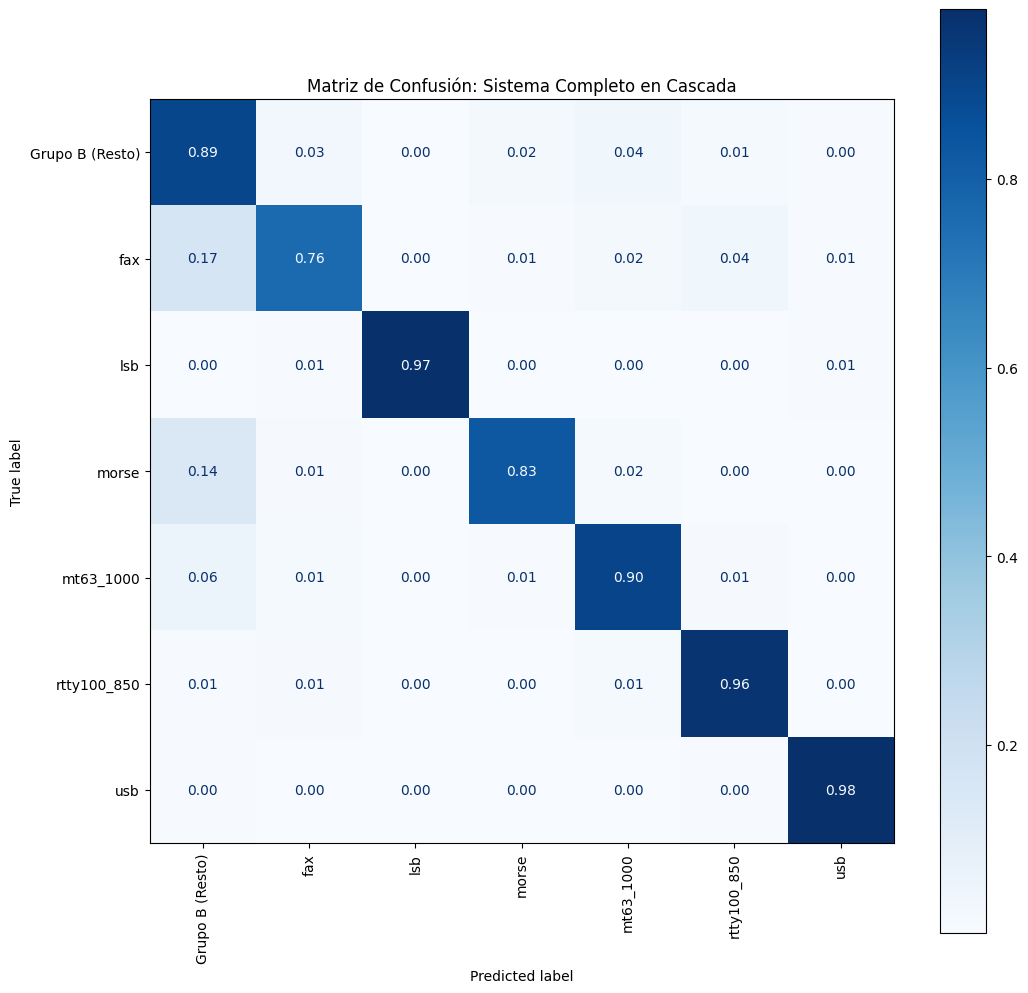


--- Reporte Final del Sistema ---
                 precision    recall  f1-score   support

Grupo B (Resto)       0.97      0.89      0.93     23040
            fax       0.67      0.76      0.71      1920
            lsb       0.94      0.97      0.96      1920
          morse       0.76      0.83      0.79      1920
      mt63_1000       0.64      0.90      0.75      1920
    rtty100_850       0.82      0.96      0.89      1920
            usb       0.93      0.98      0.95      1920

       accuracy                           0.90     34560
      macro avg       0.82      0.90      0.85     34560
   weighted avg       0.91      0.90      0.90     34560



In [39]:
# --- 6. VISUALIZAR RESULTADOS ---
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    y_true_sistema, 
    y_pred_sistema, 
    cmap='Blues', 
    normalize='true',
    xticks_rotation='vertical',
    values_format='.2f',
    ax=ax
)
plt.title("Matriz de Confusión: Sistema Completo en Cascada")
plt.show()

print("\n--- Reporte Final del Sistema ---")
print(classification_report(y_true_sistema, y_pred_sistema))

# Decisor en Cat B

## Crear Dataset CatB

In [13]:
print(f"Cargando datos desde: {DATA_FILE}")

df = pd.read_pickle(DATA_FILE)
print(f"Dataset cargado. Shape: {df.shape}")

# 1. Definir quiénes NO queremos (La lista A)
clases_cat_A = [
    'fax', 'lsb', 'morse', 'mt63_1000', 'rtty100_850', 'usb'
]

# 2. Filtrar por NEGACIÓN (~)
# "Quédate con las filas donde el modo NO esté en la lista A"
print("Aislando Categoría B...")

# .str.strip() elimina espacios en blanco por seguridad
mask_B = ~df[' mode'].str.strip().isin(clases_cat_A) 
df_B = df[mask_B].copy()

# 3. Limpieza y Reset
df_B.reset_index(drop=True, inplace=True)

# 4. VERIFICACIÓN
print("-" * 30)
print(f"Tamaño Categoría B: {df_B.shape}")
print("Clases en este dataset (Deben ser solo las digitales complejas):")
print(df_B[' mode'].unique())
print("-" * 30)

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Dataset cargado. Shape: (172800, 4098)
Aislando Categoría B...
------------------------------
Tamaño Categoría B: (115200, 4098)
Clases en este dataset (Deben ser solo las digitales complejas):
['psk31' 'psk63' 'qpsk31' 'rtty45_170' 'rtty50_170' 'olivia8_250'
 'olivia16_500' 'olivia16_1000' 'olivia32_1000' 'dominoex11' 'navtex' 'am']
------------------------------


In [14]:
ruta_guardar_pickle = BASE_PATH / 'dataset_categoria_B.pkl'

print(f"Guardando DataFrame en (formato Pickle): {ruta_guardar_pickle}")
df_B.to_pickle(ruta_guardar_pickle)
print("¡Guardado con éxito!")

Guardando DataFrame en (formato Pickle): C:\inteligencia_en_red\dataset_categoria_B.pkl
¡Guardado con éxito!


## Entrenamiento

In [15]:
DATA_FILE_B = BASE_PATH / 'dataset_categoria_B.pkl'


print(f"Cargando datos desde: {DATA_FILE_B}")

df_B = pd.read_pickle(DATA_FILE_B)
print(f"Dataset cargado. Shape: {df_B.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_categoria_B.pkl
Dataset cargado. Shape: (115200, 4098)


In [ ]:
# Reducir los datos para hacer una primera prueba

df_reducido, _ = train_test_split(df_B, train_size=0.2, stratify=df_B[' mode'], random_state=42)

print(f"Tamaño reducido: {len(df_reducido)}")

Tamaño reducido: 23040


In [17]:
X = df_reducido.drop(' mode', axis = 1)
y_raw = df_reducido[' mode']

# 2. CODIFICAR ETIQUETAS (Vital: Creamos un encoder NUEVO solo para B)
le_B = LabelEncoder()
y = le_B.fit_transform(y_raw)
print(f"Clases codificadas para B: {le_B.classes_}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Clases codificadas para B: ['am' 'dominoex11' 'navtex' 'olivia16_1000' 'olivia16_500' 'olivia32_1000'
 'olivia8_250' 'psk31' 'psk63' 'qpsk31' 'rtty45_170' 'rtty50_170']


In [ ]:
# 3. CONFIGURACIÓN DEL MODELO
# Usamos la configuración robusta que te funcionó, pero quizás
# necesitemos un poco más de profundidad (max_depth=6) porque estas señales son complejas.
print("Entrenando Especialista B...")

clf_cat_B = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    
    max_depth=6,             # Subimos un poco la profundidad (de 4 a 6)
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.4,    # Miramos un poco más de columnas (40%)
    
    gamma=1,
    reg_alpha=1,             # Bajamos un poco la regularización agresiva
    reg_lambda=5,            # para dejarle aprender detalles finos de las fases
    
    objective='multi:softprob', # Multiclase
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # GPU activada
    early_stopping_rounds=50
)

clf_cat_B.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entrenando Especialista B...
[0]	validation_0-mlogloss:2.47193	validation_1-mlogloss:2.48365
[50]	validation_0-mlogloss:1.88013	validation_1-mlogloss:2.43455


c:\inteligencia_en_red\env\Lib\site-packages\xgboost\core.py:774: UserWarning: [13:42:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



--- Reporte Especialista B ---
               precision    recall  f1-score   support

           am       0.14      0.13      0.13       384
   dominoex11       0.15      0.14      0.14       384
       navtex       0.15      0.12      0.14       384
olivia16_1000       0.28      0.38      0.32       384
 olivia16_500       0.12      0.10      0.11       384
olivia32_1000       0.31      0.39      0.35       384
  olivia8_250       0.08      0.07      0.08       384
        psk31       0.21      0.21      0.21       384
        psk63       0.18      0.18      0.18       384
       qpsk31       0.11      0.11      0.11       384
   rtty45_170       0.11      0.10      0.10       384
   rtty50_170       0.10      0.10      0.10       384

     accuracy                           0.17      4608
    macro avg       0.16      0.17      0.16      4608
 weighted avg       0.16      0.17      0.16      4608



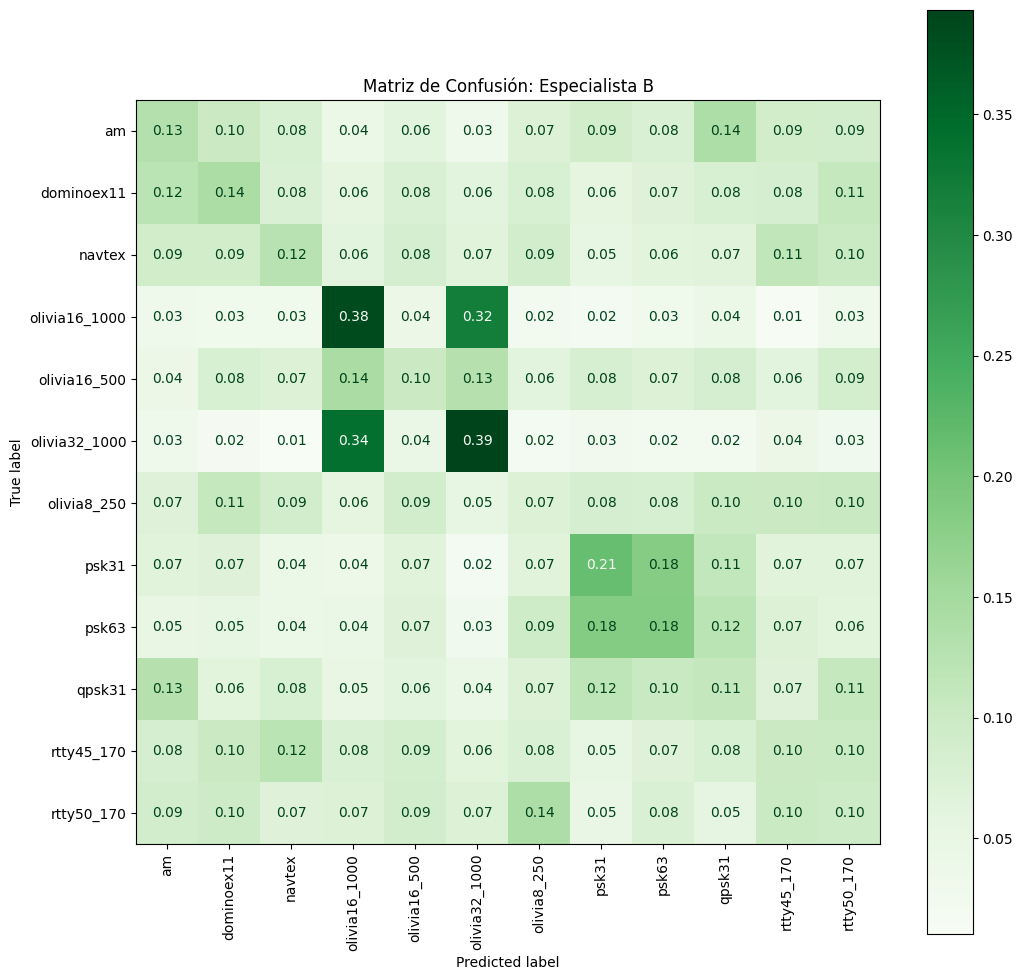

In [ ]:
# 4. EVALUACIÓN
y_pred = clf_cat_B.predict(X_test)
nombres_reales = le_B.inverse_transform(y_test)
nombres_pred = le_B.inverse_transform(y_pred)

print("\n--- Reporte Especialista B ---")
print(classification_report(nombres_reales, nombres_pred))

# Matriz
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    nombres_reales, nombres_pred, 
    cmap='Greens', # Usamos verde para distinguirlo visualmente del A
    normalize='true', 
    xticks_rotation='vertical',
    values_format='.2f',
    ax=ax
)
plt.title("Matriz de Confusión: Especialista B")
plt.show()

## Creamos sub categorías: olivia, psk, rtty, domino, am, navtex

In [3]:
def agrupar_familias(nombre_modo):
    modo = nombre_modo.strip().lower()
    
    if 'olivia' in modo:
        return 'Familia Olivia'
    elif 'psk' in modo or 'qpsk' in modo:
        return 'Familia PSK'
    elif 'domino' in modo:
        return 'Familia Domino'
    else:
        return 'DESCARTAR' # Marcamos para borrar (AM, Navtex, RTTY, etc.)

In [5]:
DATA_FILE_B = BASE_PATH / 'dataset_categoria_B.pkl'


print(f"Cargando datos desde: {DATA_FILE_B}")

df_trabajo = pd.read_pickle(DATA_FILE_B)
print(f"Dataset cargado. Shape: {df_trabajo.shape}")

Cargando datos desde: C:\inteligencia_en_red\dataset_categoria_B.pkl
Dataset cargado. Shape: (115200, 4098)


In [18]:
# Reducir los datos para hacer una primera prueba

df_trabajo, _ = train_test_split(df_B, train_size=0.2, stratify=df_B[' mode'], random_state=42)

print(f"Tamaño reducido: {len(df_reducido)}")

Tamaño reducido: 23040


In [6]:
# Aplicamos la función
print("Agrupando clases en familias...")
df_trabajo['familia'] = df_trabajo[' mode'].apply(agrupar_familias)

# 3. FILTRADO: Nos quedamos SOLO con las 3 familias
print(f"Tamaño antes de limpiar: {df_trabajo.shape}")
df_familias = df_trabajo[df_trabajo['familia'] != 'DESCARTAR'].copy()
print(f"Tamaño FINAL (Solo Digitales Puras): {df_familias.shape}")

# Verificamos que no se ha colado nada raro
print("\nClases finales para entrenar:")
print(df_familias['familia'].value_counts())

# Verificamos la nueva distribución
print("\n--- Nuevas Clases (Familias) ---")
print(df_trabajo['familia'].value_counts())

Agrupando clases en familias...
Tamaño antes de limpiar: (115200, 4099)
Tamaño FINAL (Solo Digitales Puras): (76800, 4099)

Clases finales para entrenar:
familia
Familia Olivia    38400
Familia PSK       28800
Familia Domino     9600
Name: count, dtype: int64

--- Nuevas Clases (Familias) ---
familia
DESCARTAR         38400
Familia Olivia    38400
Familia PSK       28800
Familia Domino     9600
Name: count, dtype: int64


In [7]:
X = df_trabajo.drop([' mode', 'familia'], axis = 1)
y_raw = df_trabajo['familia']

# 2. CODIFICAR ETIQUETAS (Vital: Creamos un encoder NUEVO solo para B)
le_B = LabelEncoder()
y = le_B.fit_transform(y_raw)
print(f"Clases codificadas para B: {le_B.classes_}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Clases codificadas para B: ['DESCARTAR' 'Familia Domino' 'Familia Olivia' 'Familia PSK']


In [8]:
from sklearn.utils.class_weight import compute_sample_weight

# Al no poner pesos el desbalance el altisimo

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [9]:
print("Entrenando Especialista en Familias (Configuración Anti-Overfitting)...")

clf_familias = XGBClassifier(
    n_estimators=3000,       # Subimos árboles porque aprenderemos más lento
    learning_rate=0.02,      # <--- BAJAMOS: Aprender muy despacio evita memorizar de golpe
    
    # --- FRENOS MECÁNICOS (Estructura del Árbol) ---
    max_depth=3,             # <--- CRÍTICO: Árboles poco profundos. Evita complejidad innecesaria.
    min_child_weight=10,     # <--- SUBIMOS: Necesita mucha evidencia para crear una rama.
    
    # --- FRENOS DE ALEATORIEDAD ---
    subsample=0.6,           # Usamos solo el 60% de datos por árbol (más variación)
    colsample_bytree=0.3,    # Miramos solo el 30% de columnas.
    
    # --- FRENOS MATEMÁTICOS (Regularización Extrema) ---
    gamma=5,                 # <--- Poda agresiva. Si la ganancia es baja, no divide.
    reg_alpha=20,            # <--- L1 muy alto: Elimina ruido.
    reg_lambda=20,           # <--- L2 muy alto: Suaviza los pesos.
    
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # GPU activada
    early_stopping_rounds=50
)

clf_familias.fit(
    X_train, y_train,
    sample_weight=sample_weights,   # Mantenemos los pesos para el desbalance
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entrenando Especialista en Familias (Configuración Anti-Overfitting)...
[0]	validation_0-mlogloss:1.38600	validation_1-mlogloss:1.38604
[50]	validation_0-mlogloss:1.37419	validation_1-mlogloss:1.37614
[100]	validation_0-mlogloss:1.36402	validation_1-mlogloss:1.36801
[150]	validation_0-mlogloss:1.35433	validation_1-mlogloss:1.36031
[200]	validation_0-mlogloss:1.34494	validation_1-mlogloss:1.35280
[250]	validation_0-mlogloss:1.33625	validation_1-mlogloss:1.34611
[300]	validation_0-mlogloss:1.32813	validation_1-mlogloss:1.33987
[350]	validation_0-mlogloss:1.32045	validation_1-mlogloss:1.33410
[400]	validation_0-mlogloss:1.31290	validation_1-mlogloss:1.32851
[450]	validation_0-mlogloss:1.30544	validation_1-mlogloss:1.32289
[500]	validation_0-mlogloss:1.29805	validation_1-mlogloss:1.31733
[550]	validation_0-mlogloss:1.29131	validation_1-mlogloss:1.31225
[600]	validation_0-mlogloss:1.28431	validation_1-mlogloss:1.30696
[650]	validation_0-mlogloss:1.27767	validation_1-mlogloss:1.30209
[700]	v

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


c:\inteligencia_en_red\env\Lib\site-packages\xgboost\core.py:774: UserWarning: [14:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



--- Reporte Especialista B (Familias) ---
                precision    recall  f1-score   support

     DESCARTAR       0.45      0.29      0.35      7680
Familia Domino       0.14      0.24      0.18      1920
Familia Olivia       0.63      0.62      0.62      7680
   Familia PSK       0.50      0.63      0.55      5760

      accuracy                           0.48     23040
     macro avg       0.43      0.44      0.43     23040
  weighted avg       0.50      0.48      0.48     23040



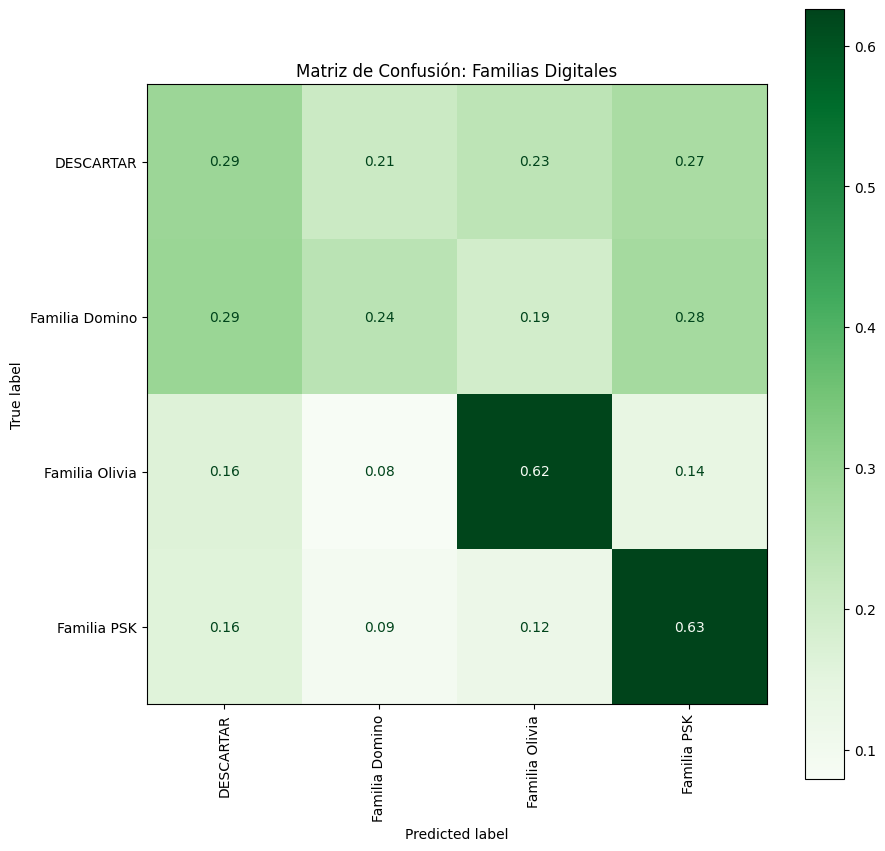

In [10]:
# 4. EVALUAR
y_pred = clf_familias.predict(X_test)
nombres_reales = le_B.inverse_transform(y_test)
nombres_pred = le_B.inverse_transform(y_pred)

print("\n--- Reporte Especialista B (Familias) ---")
print(classification_report(nombres_reales, nombres_pred))

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    nombres_reales, nombres_pred, 
    cmap='Greens', 
    normalize='true', 
    xticks_rotation='vertical',
    values_format='.2f',
    ax=ax
)
plt.title("Matriz de Confusión: Familias Digitales")
plt.show()

## Cambiamos a Frecuencia

In [15]:
# --- 1. CARGAR Y DEFINIR FAMILIAS ---
print("Cargando dataset...")
# Asegúrate de cargar el dataset grande
df_full = pd.read_pickle(BASE_PATH / 'dataset_categoria_B.pkl')

Cargando dataset...


In [16]:
def definir_familia(modo):
    m = modo.strip().lower()
    if 'olivia' in m: return 'Familia Olivia'
    if 'psk' in m or 'qpsk' in m: return 'Familia PSK'
    if 'domino' in m: return 'Familia Domino'
    return 'DESCARTAR'

In [ ]:
print("Agrupando y Limpiando...")
df_full['familia'] = df_full[' mode'].apply(definir_familia)

# FILTRO ESTRICTO: Nos quedamos SOLO con las 3 familias
df_fft = df_full[df_full['familia'] != 'DESCARTAR'].copy()

print(f"Clases finales: {df_fft['familia'].unique()}")
print(f"Muestras totales: {len(df_fft)}")

Agrupando y Limpiando...
Clases finales: ['Familia PSK' 'DESCARTAR' 'Familia Olivia' 'Familia Domino']
Muestras totales: 115200


In [18]:
# --- 2. LA MAGIA: TRANSFORMADA DE FOURIER (FFT) ---
print("Calculando FFT (Pasando del Tiempo a la Frecuencia)...")

# a) Extraemos las muestras crudas
X_time = df_fft.drop([' mode', 'familia'], axis = 1) # Matriz de (N, 4096)

# b) Aplicamos FFT
# np.fft.fft calcula la transformada.
# np.abs extrae la MAGNITUD (la fuerza de la señal en cada frecuencia), ignorando la fase.
X_freq_full = np.abs(np.fft.fft(X_time, axis=1))

# c) Optimización: Nos quedamos con la mitad
# La salida de la FFT es simétrica. La segunda mitad es un espejo de la primera.
# Nos quedamos solo con las primeras 2048 columnas.
X_fft = X_freq_full[:, :2048]

print(f"Datos transformados. Forma original: {X_time.shape} -> Forma FFT: {X_fft.shape}")

Calculando FFT (Pasando del Tiempo a la Frecuencia)...
Datos transformados. Forma original: (115200, 4097) -> Forma FFT: (115200, 2048)


In [19]:
from sklearn.utils.class_weight import compute_sample_weight
# --- 3. PREPARAR EL ENTRENAMIENTO ---
y_labels = df_fft['familia']

# Codificar etiquetas
le = LabelEncoder()
y = le.fit_transform(y_labels)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_fft, y, test_size=0.2, stratify=y, random_state=42
)

# Pesos (Siguen siendo necesarios por el desbalance de Domino)
weights = compute_sample_weight('balanced', y_train)

In [20]:
# --- 4. ENTRENAR XGBOOST ---
print("Entrenando Especialista B (Versión FFT)...")

clf_fft = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    
    # Ahora podemos ser un poco más profundos porque los datos tienen sentido
    max_depth=5,             
    min_child_weight=5,
    
    subsample=0.8,
    colsample_bytree=0.4,
    
    gamma=1,
    reg_alpha=2,
    reg_lambda=5,
    
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # GPU
    early_stopping_rounds=50
)

clf_fft.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

Entrenando Especialista B (Versión FFT)...
[0]	validation_0-mlogloss:1.36552	validation_1-mlogloss:1.36619
[100]	validation_0-mlogloss:0.78016	validation_1-mlogloss:0.81212
[200]	validation_0-mlogloss:0.63034	validation_1-mlogloss:0.68223
[300]	validation_0-mlogloss:0.54119	validation_1-mlogloss:0.61167
[400]	validation_0-mlogloss:0.47784	validation_1-mlogloss:0.56654
[500]	validation_0-mlogloss:0.42707	validation_1-mlogloss:0.53232
[600]	validation_0-mlogloss:0.38551	validation_1-mlogloss:0.50645
[700]	validation_0-mlogloss:0.35007	validation_1-mlogloss:0.48575
[800]	validation_0-mlogloss:0.32044	validation_1-mlogloss:0.46931
[900]	validation_0-mlogloss:0.29480	validation_1-mlogloss:0.45608
[1000]	validation_0-mlogloss:0.27139	validation_1-mlogloss:0.44416
[1100]	validation_0-mlogloss:0.25081	validation_1-mlogloss:0.43413
[1200]	validation_0-mlogloss:0.23226	validation_1-mlogloss:0.42507
[1300]	validation_0-mlogloss:0.21564	validation_1-mlogloss:0.41743
[1400]	validation_0-mlogloss:0.

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.4
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None



--- REPORTE FFT ---
                precision    recall  f1-score   support

     DESCARTAR       0.87      0.89      0.88      7680
Familia Domino       0.78      0.49      0.60      1920
Familia Olivia       0.91      0.91      0.91      7680
   Familia PSK       0.83      0.91      0.87      5760

      accuracy                           0.87     23040
     macro avg       0.85      0.80      0.82     23040
  weighted avg       0.87      0.87      0.86     23040



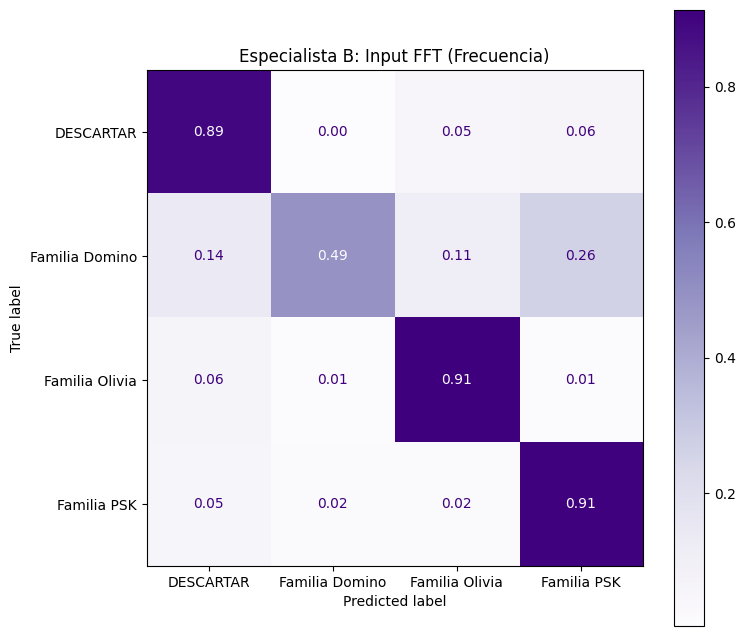

In [21]:
# --- 5. EVALUAR ---
y_pred = clf_fft.predict(X_test)
names = le.inverse_transform(y_test)
preds = le.inverse_transform(y_pred)

print("\n--- REPORTE FFT ---")
print(classification_report(names, preds))

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    names, preds, 
    cmap='Purples', 
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Especialista B: Input FFT (Frecuencia)")
plt.show()

## Frecuencia y logaritmica

In [36]:
from sklearn.utils.class_weight import compute_sample_weight
# 1. CARGAR DATASET COMPLETO
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_categoria_B.pkl')

# 2. DEFINIR CLASES (INCLUYENDO 'RESTO')
def definir_familia_total(modo):
    m = modo.strip().lower()
    if 'olivia' in m: return 'Familia Olivia'
    if 'psk' in m or 'qpsk' in m: return 'Familia PSK'
    if 'domino' in m: return 'Familia Domino'
    # Aquí metemos todo lo demás (AM, Navtex, RTTY...)
    return 'RESTO (AM/RTTY/etc)' 

print("Agrupando...")
df_full['familia'] = df_full[' mode'].apply(definir_familia_total)

# Ya NO filtramos. Usamos todo.
df_fft = df_full.copy()
print(f"Clases a entrenar: {df_fft['familia'].unique()}")

# 3. FFT LOGARÍTMICA (EL TRUCO MAESTRO)
print("Calculando FFT Logarítmica...")

X_time = df_fft.drop([' mode', 'familia'], axis = 1)

# a) FFT normal
X_freq_raw = np.abs(np.fft.fft(X_time, axis=1))
X_fft_half = X_freq_raw[:, :2048] # Nos quedamos la mitad

# b) ¡LOGARITMO! (Simulamos Decibelios)
# np.log1p calcula log(1 + x) para evitar error si hay ceros
X_fft_log = np.log1p(X_fft_half) 

print("Transformación completada.")

# 4. PREPARAR ENTRENAMIENTO
y_labels = df_fft['familia']
le = LabelEncoder()
y = le.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X_fft_log, y, test_size=0.2, stratify=y, random_state=42
)

# 5. PESOS MANUALES (Para salvar a Domino)
# Calculamos los pesos 'balanced' base
weights_base = compute_sample_weight('balanced', y_train)

# Truco: Multiplicamos x2 el peso de las filas que sean Domino
# Primero averiguamos qué número es Domino en el encoder
try:
    idx_domino = list(le.classes_).index('Familia Domino')
    # Aumentamos el peso SOLO donde y_train sea Domino
    weights_final = np.where(y_train == idx_domino, weights_base * 2.5, weights_base)
    print("⚡ Pesos de Domino duplicados para forzar aprendizaje.")
except:
    weights_final = weights_base
    print("Aviso: No se encontró clase Domino para potenciar.")

# 6. ENTRENAR
print("Entrenando Modelo Unificado (FFT Log)...")

clf_total = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=5,             
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.4,
    gamma=1,
    reg_alpha=2,
    reg_lambda=5,
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           
    early_stopping_rounds=50
)

clf_total.fit(
    X_train, y_train,
    sample_weight=weights_final, # Usamos los pesos trucados
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


Cargando dataset...
Agrupando...
Clases a entrenar: ['Familia PSK' 'RESTO (AM/RTTY/etc)' 'Familia Olivia' 'Familia Domino']
Calculando FFT Logarítmica...
Transformación completada.
⚡ Pesos de Domino duplicados para forzar aprendizaje.
Entrenando Modelo Unificado (FFT Log)...
[0]	validation_0-mlogloss:1.42500	validation_1-mlogloss:1.42547
[100]	validation_0-mlogloss:0.94209	validation_1-mlogloss:0.97292
[200]	validation_0-mlogloss:0.76421	validation_1-mlogloss:0.81686
[300]	validation_0-mlogloss:0.65662	validation_1-mlogloss:0.72924
[400]	validation_0-mlogloss:0.57630	validation_1-mlogloss:0.66705
[500]	validation_0-mlogloss:0.51183	validation_1-mlogloss:0.61981
[600]	validation_0-mlogloss:0.46027	validation_1-mlogloss:0.58401
[700]	validation_0-mlogloss:0.41612	validation_1-mlogloss:0.55468
[800]	validation_0-mlogloss:0.37770	validation_1-mlogloss:0.52956
[900]	validation_0-mlogloss:0.34523	validation_1-mlogloss:0.50948
[1000]	validation_0-mlogloss:0.31582	validation_1-mlogloss:0.49105

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.4
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None



--- REPORTE FINAL UNIFICADO ---
                     precision    recall  f1-score   support

     Familia Domino       0.70      0.54      0.61      1920
     Familia Olivia       0.91      0.90      0.91      7680
        Familia PSK       0.84      0.90      0.87      5760
RESTO (AM/RTTY/etc)       0.87      0.88      0.88      7680

           accuracy                           0.87     23040
          macro avg       0.83      0.81      0.82     23040
       weighted avg       0.86      0.87      0.86     23040



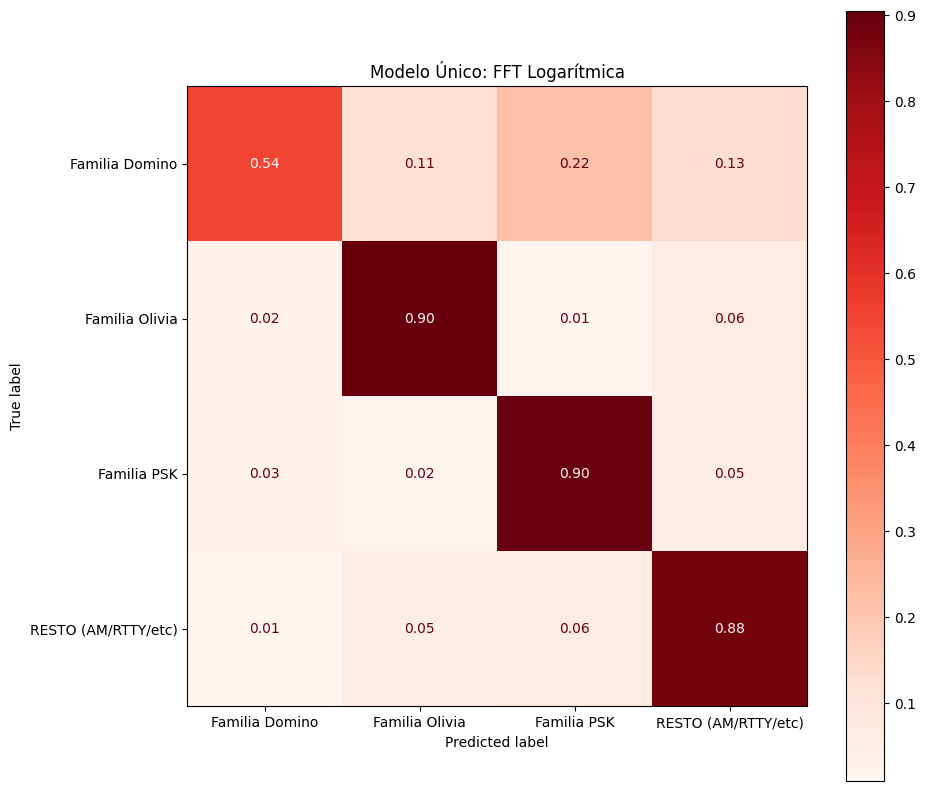

In [37]:
# 7. EVALUAR
y_pred = clf_total.predict(X_test)
names = le.inverse_transform(y_test)
preds = le.inverse_transform(y_pred)

print("\n--- REPORTE FINAL UNIFICADO ---")
print(classification_report(names, preds))

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    names, preds, 
    cmap='Reds', # Nuevo color para celebrar
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Modelo Único: FFT Logarítmica")
plt.show()

In [38]:
# Guardar
pkg = {'modelo': clf_total, 'encoder': le, 'tipo': 'Unificado FFT Log', 'requiere_fft_log': True}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_unificado_fft.joblib')

['C:\\inteligencia_en_red\\modelos\\modelo_unificado_fft.joblib']

# Prueba arquitectura en cascada Cat A y Cat B

In [2]:
# --- 1. CONFIGURACIÓN ---
BASE_PATH = Path(r'C:/inteligencia_en_red') # Usando tu ruta actual
MODELOS_DIR = BASE_PATH / 'modelos'
DATA_FILE = BASE_PATH / 'dataset_completo.pkl' # O dataset_completo

print("🏗️ Montando el Sistema Híbrido...")

try:
    pkg_cat = joblib.load(MODELOS_DIR / 'modelo_xgboost_portero_v2.joblib')
except:
    pkg_cat = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_categorias.joblib')
model_portero = pkg_cat['modelo']

# B) Especialista A (Raw Data)
pkg_A = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_cat_A.joblib')
# Nota: Si entrenaste el A v2 (con AM), carga 'modelo_xgboost_especialista_A_v2.joblib'
model_A = pkg_A['modelo']
le_A = pkg_A['encoder']

# C) Especialista B (FFT Data - El nuevo)
pkg_B = joblib.load(MODELOS_DIR / 'modelo_unificado_fft.joblib')
model_B = pkg_B['modelo']
le_B = pkg_B['encoder']

print("✅ Cerebros cargados: Portero + Especialista A + Especialista B (FFT)")

🏗️ Montando el Sistema Híbrido...
✅ Cerebros cargados: Portero + Especialista A + Especialista B (FFT)


In [3]:
# --- 2. DEFINICIÓN MAESTRA DE GRUPOS (TU REGLA DE ORO) ---
# Aquí definimos exactamente qué va en cada sitio para evitar confusiones

LISTA_EXACTA_A = ['fax', 'lsb', 'morse', 'mt63_1000', 'rtty100_850', 'usb']

def normalizar_etiqueta_final(etiqueta_cruda):
    """
    Convierte cualquier etiqueta (raw) en la etiqueta visual final.
    """
    # 1. Limpieza básica
    lbl = str(etiqueta_cruda).strip().lower()
    
    # 2. ¿Es Categoría A? (Debe coincidir exactamente)
    if lbl in LISTA_EXACTA_A:
        return lbl # Devuelve 'fax', 'usb', etc.
    
    # 3. ¿Es Categoría B? (Familias y Resto)
    if 'olivia' in lbl: return 'Familia Olivia'
    if 'psk' in lbl or 'qpsk' in lbl: return 'Familia PSK'
    if 'domino' in lbl: return 'Familia Domino'
    
    # El resto específico que mencionaste (am, navtex, rtty45, rtty50)
    # Como ya hemos chequeado A, todo lo que queda va a RESTO
    return 'RESTO'


In [4]:
# --- 3. PREPARAR DATOS DE TEST ---
print(f"Cargando datos desde: {DATA_FILE}")
# Detectamos formato
if str(DATA_FILE).endswith('.parquet'):
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_pickle(DATA_FILE)

# DEFINICIÓN DE GRUPOS (CRUCIAL PARA LA EVALUACIÓN)
# Esto debe coincidir con cómo entrenaste al Portero.
# Si usaste la versión mejorada, AM, Navtex y RTTY están en A.
clases_grupo_A = [
    'fax', 'lsb', 'morse', 'mt63_1000', 'usb', 
    'am', 'navtex', 'rtty100_850', 'rtty45_170', 'rtty50_170'
]

# Separamos X e y
X_completo = df.drop([' mode'], axis = 1)
y_nombres = df[' mode'] # o 'mode ' con espacio si tu df lo tiene así

# Split de Test
_, X_test, _, y_test_real = train_test_split(
    X_completo, y_nombres, test_size=0.2, stratify=y_nombres, random_state=42
)
print(f"Datos de prueba listos: {len(X_test)} muestras.")

Cargando datos desde: C:\inteligencia_en_red\dataset_completo.pkl
Datos de prueba listos: 34560 muestras.


In [5]:
# --- 4. FUNCIÓN MÁGICA DE PREDICCIÓN (HÍBRIDA) ---
def predecir_sistema_optimizado(X):
    # Convertimos a DataFrame si no lo es, para asegurar que .iloc funcione
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
        
    # 1. PORTERO (Predice todo el bloque de una vez)
    print("   -> Portero clasificando...")
    preds_portero = model_portero.predict(X)
    
    # Preparamos el array final lleno de vacíos
    # Usamos dtype=object para guardar strings
    preds_finales = np.empty(len(X), dtype=object)
    
    # 2. SEPARAR ÍNDICES (Vectorización)
    # Asumimos que 1 = Categoría A, 0 = Categoría B
    # (Si tu portero usa 0 para A, invierte estos números)
    idx_A = np.where(preds_portero == 1)[0]
    idx_B = np.where(preds_portero == 0)[0]
    
    # 3. PROCESAR BLOQUE A (Raw)
    if len(idx_A) > 0:
        print(f"   -> Procesando {len(idx_A)} señales de Grupo A...")
        X_subset_A = X.iloc[idx_A]
        
        # Predicción masiva
        p_num_A = model_A.predict(X_subset_A)
        p_nom_A = le_A.inverse_transform(p_num_A)
        
        # Guardar en sus posiciones originales
        preds_finales[idx_A] = p_nom_A
        
    # 4. PROCESAR BLOQUE B (FFT + Log)
    if len(idx_B) > 0:
        print(f"   -> Procesando {len(idx_B)} señales de Grupo B (Calculando FFT)...")
        X_subset_B = X.iloc[idx_B].values # Necesitamos numpy array
        
        # --- LA MAGIA VECTORIZADA ---
        # Calculamos la FFT de miles de filas A LA VEZ (Cero bucles)
        X_freq = np.abs(np.fft.fft(X_subset_B, axis=1))
        X_fft = X_freq[:, :2048] # Recorte
        X_log = np.log1p(X_fft)  # Logaritmo
        # ----------------------------
        
        # Predicción masiva
        p_num_B = model_B.predict(X_log)
        p_nom_B = le_B.inverse_transform(p_num_B)
        
        # Guardar en sus posiciones originales
        preds_finales[idx_B] = p_nom_B
        
    return preds_finales

# --- EJECUCIÓN ---
print("🚀 Iniciando predicción TURBO...")
import time
start = time.time()

y_pred_raw = predecir_sistema_optimizado(X_test)

end = time.time()
print(f"✅ ¡Terminado en {end - start:.2f} segundos!")

🚀 Iniciando predicción TURBO...
   -> Portero clasificando...


c:\inteligencia_en_red\env\Lib\site-packages\xgboost\core.py:774: UserWarning: [12:42:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


   -> Procesando 13259 señales de Grupo A...
   -> Procesando 21301 señales de Grupo B (Calculando FFT)...
✅ ¡Terminado en 13.99 segundos!


🧹 Normalizando resultados...
                precision    recall  f1-score   support

           fax       0.67      0.76      0.71      1920
           lsb       0.94      0.97      0.96      1920
         morse       0.76      0.83      0.79      1920
     mt63_1000       0.64      0.90      0.75      1920
   rtty100_850       0.82      0.96      0.89      1920
           usb       0.93      0.98      0.95      1920
Familia Domino       0.92      0.88      0.90      1920
Familia Olivia       0.94      0.79      0.86      7680
   Familia PSK       0.93      0.88      0.90      5760
         RESTO       0.95      0.92      0.93      7680

      accuracy                           0.88     34560
     macro avg       0.85      0.89      0.86     34560
  weighted avg       0.89      0.88      0.88     34560



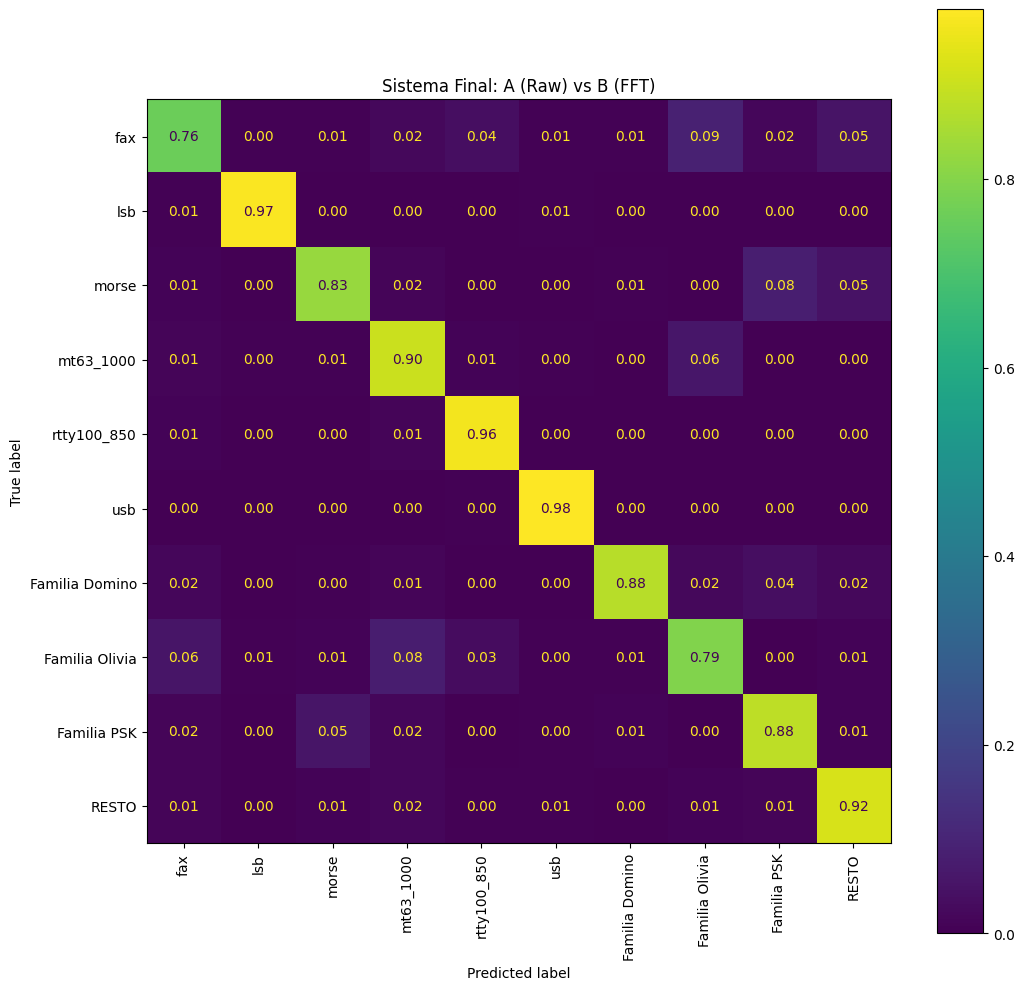

In [6]:
# --- 6. EVALUACIÓN (MAPEO DE ETIQUETAS) ---
# Para comparar peras con peras, tenemos que transformar las etiquetas REALES
# al formato que escupe el sistema (Nombres específicos para A, Familias para B).

print("🧹 Normalizando resultados...")

# Aplicamos la función maestra a AMBOS lados
y_true_clean = [normalizar_etiqueta_final(y) for y in y_test_real]
y_pred_clean = [normalizar_etiqueta_final(y) for y in y_pred_raw]

# Definimos el orden bonito para la matriz
labels_ordenados = [
    # Grupo A
    'fax', 'lsb', 'morse', 'mt63_1000', 'rtty100_850', 'usb',
    # Grupo B
    'Familia Domino', 'Familia Olivia', 'Familia PSK', 'RESTO'
]

# Reporte
print(classification_report(y_true_clean, y_pred_clean, labels=labels_ordenados))

# Matriz
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    y_true_clean, 
    y_pred_clean, 
    labels=labels_ordenados, # ¡CRUCIAL! Esto fuerza el orden y evita duplicados
    cmap='viridis', 
    normalize='true',
    xticks_rotation='vertical',
    values_format='.2f',
    ax=ax
)
plt.title("Sistema Final: A (Raw) vs B (FFT)")
plt.show()

# Decisor del RESTO

## En frecuencia

In [11]:
# 1. CARGAR DATASET GIGANTE
print("Cargando dataset completo...")
# Asegúrate de usar el dataset filtrado o el completo que tengas
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

Cargando dataset completo...


In [12]:
# 2. DEFINIR QUIÉNES SON 'RESTO'
# Estas son las clases que quedaron agrupadas en el paso anterior
clases_resto = [
    'am', 
    'navtex', 
    'rtty45_170', 
    'rtty50_170' 
    # Nota: rtty100_850 lo pusimos en el Grupo A, ¿verdad? 
    # Si quieres meterlo aquí también, añádelo a la lista.
]

print(f"Filtrando solo clases RESTO: {clases_resto}")

# Filtramos usando strip() para seguridad
mask_resto = df_full[' mode'].str.strip().isin(clases_resto)
df_resto = df_full[mask_resto].copy()

print(f"Muestras encontradas: {len(df_resto)}")
print(df_resto[' mode'].value_counts())

Filtrando solo clases RESTO: ['am', 'navtex', 'rtty45_170', 'rtty50_170']
Muestras encontradas: 38400
 mode
rtty45_170    9600
rtty50_170    9600
navtex        9600
am            9600
Name: count, dtype: int64


In [14]:
# 3. TRANSFORMACIÓN FFT LOGARÍTMICA (Vital para AM y RTTY)
print("Calculando FFT Logarítmica...")

X_time = df_resto.drop(' mode', axis = 1)

# FFT
X_freq = np.abs(np.fft.fft(X_time, axis=1))
# Mitad y Logaritmo
X_fft_log = np.log1p(X_freq[:, :2048])

print("Datos transformados.")

Calculando FFT Logarítmica...
Datos transformados.


In [18]:
# 4. PREPARAR SPLIT
y_raw = df_resto[' mode'].str.strip() # Limpiamos nombres

le_resto = LabelEncoder()
y = le_resto.fit_transform(y_raw)
print(f"Clases a predecir: {le_resto.classes_}")

X_train, X_test, y_train, y_test = train_test_split(
    X_fft_log, y, test_size=0.2, stratify=y, random_state=42
)

# Pesos (AM y Navtex suelen ser pocas muestras, esto ayuda)
weights = compute_sample_weight('balanced', y_train)

Clases a predecir: ['am' 'navtex' 'rtty45_170' 'rtty50_170']


Entrenando Sub-Especialista RESTO...
[0]	validation_0-mlogloss:1.36576	validation_1-mlogloss:1.36785
[50]	validation_0-mlogloss:0.87515	validation_1-mlogloss:0.93392
[100]	validation_0-mlogloss:0.71141	validation_1-mlogloss:0.80978
[150]	validation_0-mlogloss:0.62097	validation_1-mlogloss:0.75466
[200]	validation_0-mlogloss:0.55944	validation_1-mlogloss:0.72334
[250]	validation_0-mlogloss:0.51148	validation_1-mlogloss:0.70307
[300]	validation_0-mlogloss:0.47092	validation_1-mlogloss:0.68778
[350]	validation_0-mlogloss:0.43548	validation_1-mlogloss:0.67480
[400]	validation_0-mlogloss:0.40335	validation_1-mlogloss:0.66284
[450]	validation_0-mlogloss:0.37464	validation_1-mlogloss:0.65386
[500]	validation_0-mlogloss:0.34904	validation_1-mlogloss:0.64669
[550]	validation_0-mlogloss:0.32629	validation_1-mlogloss:0.64004
[600]	validation_0-mlogloss:0.30525	validation_1-mlogloss:0.63403
[650]	validation_0-mlogloss:0.28605	validation_1-mlogloss:0.62920
[700]	validation_0-mlogloss:0.26873	valida

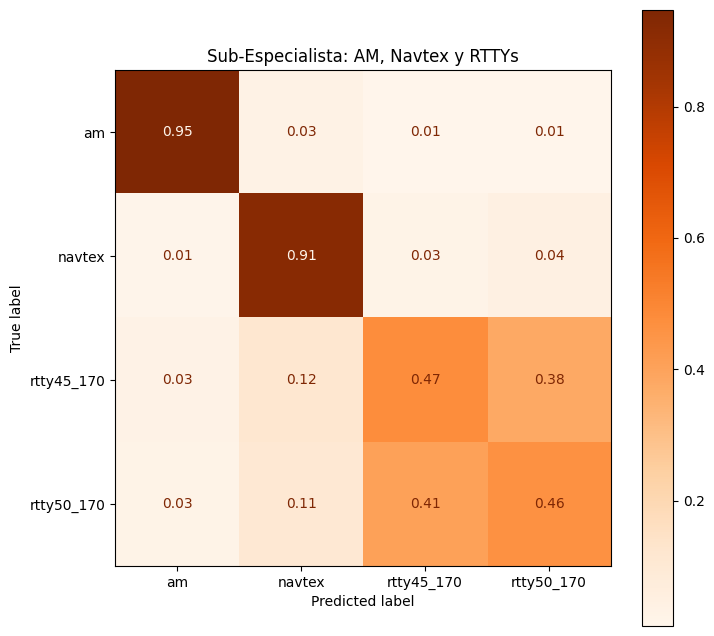

✅ Modelo guardado en: C:\inteligencia_en_red\modelos\modelo_sub_resto_fft.joblib


In [20]:
print("Entrenando Sub-Especialista RESTO...")

clf_resto = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,             # Profundidad media para captar diferencias sutiles en RTTY
    min_child_weight=3,
    
    subsample=0.8,
    colsample_bytree=0.5,    # Miramos el 50% de frecuencias
    
    gamma=1,
    reg_alpha=1,
    reg_lambda=5,
    
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',         # ¡Activa si puedes!
    early_stopping_rounds=50
)

clf_resto.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

# --- EVALUACIÓN ---
y_pred = clf_resto.predict(X_test)
names = le_resto.inverse_transform(y_test)
preds = le_resto.inverse_transform(y_pred)

print("\n--- REPORTE RESTO ---")
print(classification_report(names, preds))

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    names, preds, 
    cmap='Oranges', # Color naranja para distinguir este nivel
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Sub-Especialista: AM, Navtex y RTTYs")
plt.show()

# --- GUARDAR ---
save_path = BASE_PATH / 'modelos/modelo_sub_resto_fft.joblib'
pkg = {
    'modelo': clf_resto, 
    'encoder': le_resto, 
    'tipo': 'Sub-Especialista Resto (FFT)',
    'requiere_fft_log': True
}
joblib.dump(pkg, save_path)
print(f"✅ Modelo guardado en: {save_path}")

## En tiempo

Cargando dataset completo...
Clases RESTO: ['rtty45_170' 'rtty50_170' 'navtex' 'am']
Preparando datos en el Dominio del Tiempo (Raw)...
Entrenando Sub-Especialista (Modo Tiempo)...
[0]	validation_0-mlogloss:1.38367	validation_1-mlogloss:1.38602
[50]	validation_0-mlogloss:1.25108	validation_1-mlogloss:1.36923
[100]	validation_0-mlogloss:1.13577	validation_1-mlogloss:1.35700
[150]	validation_0-mlogloss:1.03641	validation_1-mlogloss:1.34735
[200]	validation_0-mlogloss:0.95304	validation_1-mlogloss:1.34166
[250]	validation_0-mlogloss:0.87744	validation_1-mlogloss:1.33584
[300]	validation_0-mlogloss:0.80985	validation_1-mlogloss:1.33142
[350]	validation_0-mlogloss:0.74947	validation_1-mlogloss:1.32712
[400]	validation_0-mlogloss:0.69304	validation_1-mlogloss:1.32381
[450]	validation_0-mlogloss:0.64395	validation_1-mlogloss:1.32165
[500]	validation_0-mlogloss:0.59986	validation_1-mlogloss:1.31982
[550]	validation_0-mlogloss:0.55741	validation_1-mlogloss:1.31869
[600]	validation_0-mlogloss:0.

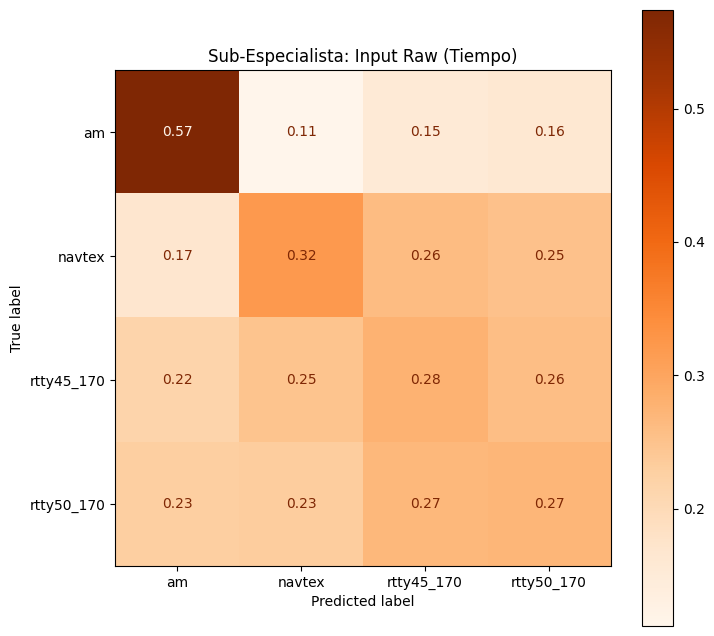

In [24]:
BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR DATASET GIGANTE
print("Cargando dataset completo...")
# Asegúrate de usar el dataset filtrado o el completo que tengas
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

clases_resto = ['am', 'navtex', 'rtty45_170', 'rtty50_170']
mask_resto = df_full[' mode'].str.strip().isin(clases_resto)
df_resto = df_full[mask_resto].copy()

print(f"Clases RESTO: {df_resto[' mode'].unique()}")

# 2. SELECCIONAR DATOS CRUDOS (SIN FFT)
print("Preparando datos en el Dominio del Tiempo (Raw)...")
X = df_resto.drop(' mode', axis = 1) # 4096 columnas directas
y_raw = df_resto[' mode'].str.strip()

# Codificar
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pesos
weights = compute_sample_weight('balanced', y_train)

# 3. ENTRENAR (Configuración Robusta)
# Como los datos en tiempo son más ruidosos que la FFT, 
# necesitamos un modelo un poco más profundo (depth=6) para encontrar patrones.
print("Entrenando Sub-Especialista (Modo Tiempo)...")

clf_resto_time = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,             # Subimos profundidad (la FFT usó 5)
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=2,             # Un poco más de regularización
    reg_lambda=10,
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',         # Activa si puedes
    early_stopping_rounds=50
)

clf_resto_time.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

# 4. EVALUAR
y_pred = clf_resto_time.predict(X_test)
names = le.inverse_transform(y_test)
preds = le.inverse_transform(y_pred)

print("\n--- REPORTE RESTO (TIEMPO) ---")
print(classification_report(names, preds))

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    names, preds, 
    cmap='Oranges', 
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Sub-Especialista: Input Raw (Tiempo)")
plt.show()

# 5. GUARDAR (Opcional, si sale mejor que el de FFT)
# joblib.dump({'modelo': clf_resto_time, 'encoder': le}, BASE_PATH / 'modelos/modelo_sub_resto_time.joblib')

## Solo rtt

### En frecuencia

Cargando dataset...
Aislando ['rtty45_170', 'rtty50_170']...
Muestras de RTTY encontradas: 19200
 mode
rtty45_170    9600
rtty50_170    9600
Name: count, dtype: int64
Calculando FFT Logarítmica de alta resolución...
Entrenando Decisor RTTY (45 vs 50)...
[0]	validation_0-logloss:0.69166	validation_1-logloss:0.69308
[100]	validation_0-logloss:0.57051	validation_1-logloss:0.69165
[160]	validation_0-logloss:0.52018	validation_1-logloss:0.69159

--- REPORTE FINAL RTTY ---
              precision    recall  f1-score   support

     RTTY 45       0.52      0.51      0.52      1920
     RTTY 50       0.52      0.53      0.53      1920

    accuracy                           0.52      3840
   macro avg       0.52      0.52      0.52      3840
weighted avg       0.52      0.52      0.52      3840



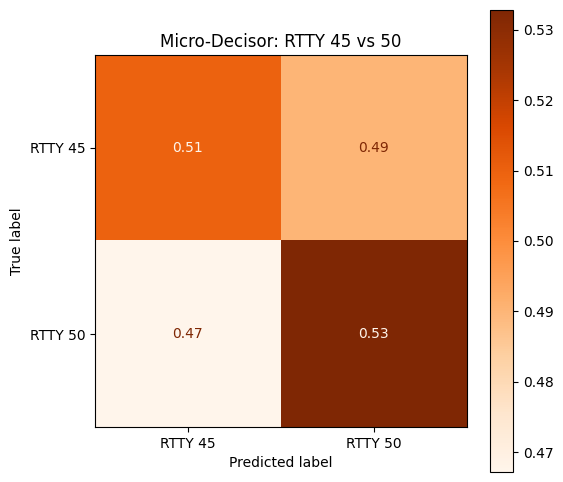

✅ Micro-Modelo Guardado.


In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR DATASET
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

# 2. FILTRAR SOLO LAS DOS RTTYs
clases_rtty = ['rtty45_170', 'rtty50_170']

print(f"Aislando {clases_rtty}...")
mask_rtty = df_full[' mode'].str.strip().isin(clases_rtty)
df_rtty = df_full[mask_rtty].copy()

print(f"Muestras de RTTY encontradas: {len(df_rtty)}")
print(df_rtty[' mode'].value_counts())

# 3. GENERAR TARGET BINARIO
# rtty45_170 = 0
# rtty50_170 = 1
df_rtty['target'] = df_rtty[' mode'].apply(lambda x: 1 if '50' in x else 0)

# 4. FFT LOGARÍTMICA (La mejor lupa para esto)
print("Calculando FFT Logarítmica de alta resolución...")

X_time = df_rtty.drop([' mode', 'target'], axis = 1)
# FFT
X_freq = np.abs(np.fft.fft(X_time, axis=1))
# Logaritmo (Esencial para ver diferencias sutiles en los bordes)
X_fft_log = np.log1p(X_freq[:, :2048])

X_train, X_test, y_train, y_test = train_test_split(
    X_fft_log, df_rtty['target'], test_size=0.2, stratify=df_rtty['target'], random_state=42
)

# 5. ENTRENAR MICRO-ESPECIALISTA
# Usamos una configuración profunda porque la diferencia es muy sutil
print("Entrenando Decisor RTTY (45 vs 50)...")

clf_rtty = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.02,      # Aprendizaje MUY lento para captar detalles finos
    max_depth=7,             # Árboles profundos para encontrar la diferencia de velocidad
    min_child_weight=3,
    
    subsample=0.8,
    colsample_bytree=0.5,
    
    gamma=0.5,               # Poca restricción, dejad que investigue
    reg_alpha=1,
    reg_lambda=1,
    
    objective='binary:logistic', # BINARIO PURO
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # GPU si tienes
    early_stopping_rounds=50
)

clf_rtty.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# 6. EVALUAR
y_pred = clf_rtty.predict(X_test)

# Nombres para la gráfica
nombres = ['RTTY 45', 'RTTY 50']

print("\n--- REPORTE FINAL RTTY ---")
print(classification_report(y_test, y_pred, target_names=nombres))

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=nombres,
    cmap='Oranges', 
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Micro-Decisor: RTTY 45 vs 50")
plt.show()

# 7. GUARDAR
pkg = {
    'modelo': clf_rtty, 
    'tipo': 'Micro-Especialista RTTY (45 vs 50)',
    'requiere_fft_log': True
}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_micro_rtty.joblib')
print("✅ Micro-Modelo Guardado.")

### Dominio tiempo

Cargando dataset...
Aislando ['rtty45_170', 'rtty50_170']...
Muestras de RTTY encontradas: 19200
 mode
rtty45_170    9600
rtty50_170    9600
Name: count, dtype: int64
Calculando FFT Logarítmica de alta resolución...
Entrenando Decisor RTTY (45 vs 50)...
[0]	validation_0-logloss:0.69199	validation_1-logloss:0.69325
[50]	validation_0-logloss:0.62505	validation_1-logloss:0.69449


c:\inteligencia_en_red\env\Lib\site-packages\xgboost\core.py:774: UserWarning: [13:21:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



--- REPORTE FINAL RTTY ---
              precision    recall  f1-score   support

     RTTY 45       0.49      0.46      0.48      1920
     RTTY 50       0.49      0.52      0.50      1920

    accuracy                           0.49      3840
   macro avg       0.49      0.49      0.49      3840
weighted avg       0.49      0.49      0.49      3840



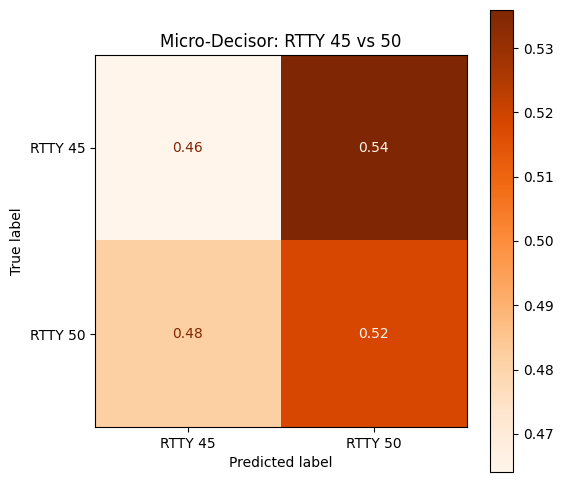

✅ Micro-Modelo Guardado.


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR DATASET
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

# 2. FILTRAR SOLO LAS DOS RTTYs
clases_rtty = ['rtty45_170', 'rtty50_170']

print(f"Aislando {clases_rtty}...")
mask_rtty = df_full[' mode'].str.strip().isin(clases_rtty)
df_rtty = df_full[mask_rtty].copy()

print(f"Muestras de RTTY encontradas: {len(df_rtty)}")
print(df_rtty[' mode'].value_counts())

# 3. GENERAR TARGET BINARIO
# rtty45_170 = 0
# rtty50_170 = 1
df_rtty['target'] = df_rtty[' mode'].apply(lambda x: 1 if '50' in x else 0)

# 4. FFT LOGARÍTMICA (La mejor lupa para esto)
print("Calculando FFT Logarítmica de alta resolución...")

X_time = df_rtty.drop([' mode', 'target'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X_time, df_rtty['target'], test_size=0.2, stratify=df_rtty['target'], random_state=42
)

# 5. ENTRENAR MICRO-ESPECIALISTA
# Usamos una configuración profunda porque la diferencia es muy sutil
print("Entrenando Decisor RTTY (45 vs 50)...")

clf_rtty = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.02,      # Aprendizaje MUY lento para captar detalles finos
    max_depth=7,             # Árboles profundos para encontrar la diferencia de velocidad
    min_child_weight=3,
    
    subsample=0.8,
    colsample_bytree=0.5,
    
    gamma=0.5,               # Poca restricción, dejad que investigue
    reg_alpha=1,
    reg_lambda=1,
    
    objective='binary:logistic', # BINARIO PURO
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           # GPU si tienes
    early_stopping_rounds=50
)

clf_rtty.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# 6. EVALUAR
y_pred = clf_rtty.predict(X_test)

# Nombres para la gráfica
nombres = ['RTTY 45', 'RTTY 50']

print("\n--- REPORTE FINAL RTTY ---")
print(classification_report(y_test, y_pred, target_names=nombres))

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=nombres,
    cmap='Oranges', 
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Micro-Decisor: RTTY 45 vs 50")
plt.show()

# 7. GUARDAR
pkg = {
    'modelo': clf_rtty, 
    'tipo': 'Micro-Especialista RTTY (45 vs 50)',
    'requiere_fft_log': True
}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_micro_rtty.joblib')
print("✅ Micro-Modelo Guardado.")

### Envelope Spectrum

Cargando dataset...
Muestras: 19200
Generando Features Híbridas (Envelope FFT + SNR)...
Features listas. Forma final: (19200, 201) (1 SNR + 200 FFT)
Entrenando Decisor RTTY con SNR...
[0]	validation_0-logloss:0.68902	validation_1-logloss:0.68921
[200]	validation_0-logloss:0.38261	validation_1-logloss:0.41354
[400]	validation_0-logloss:0.31454	validation_1-logloss:0.36902
[600]	validation_0-logloss:0.27903	validation_1-logloss:0.35528
[800]	validation_0-logloss:0.25354	validation_1-logloss:0.35033
[1000]	validation_0-logloss:0.23358	validation_1-logloss:0.34784
[1200]	validation_0-logloss:0.21641	validation_1-logloss:0.34606
[1400]	validation_0-logloss:0.20141	validation_1-logloss:0.34454
[1600]	validation_0-logloss:0.18796	validation_1-logloss:0.34388
[1800]	validation_0-logloss:0.17599	validation_1-logloss:0.34376
[1896]	validation_0-logloss:0.17048	validation_1-logloss:0.34374

--- REPORTE FINAL RTTY (CON SNR) ---
              precision    recall  f1-score   support

     RTTY 45   

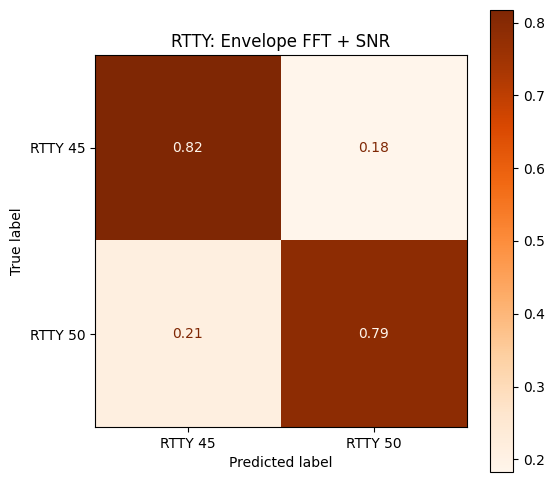

['C:\\inteligencia_en_red\\modelos\\modelo_micro_rtty_snr.joblib']

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR Y FILTRAR
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

clases_rtty = ['rtty45_170', 'rtty50_170']
mask_rtty = df_full[' mode'].str.strip().isin(clases_rtty)
df_rtty = df_full[mask_rtty].copy()
df_rtty['target'] = df_rtty[' mode'].apply(lambda x: 1 if '50' in x else 0)

print(f"Muestras: {len(df_rtty)}")

# 2. PREPARACIÓN DE CARACTERÍSTICAS (FEATURES)
print("Generando Features Híbridas (Envelope FFT + SNR)...")

# --- A) PROCESAR SNR ---
# Extraemos la columna SNR y la convertimos en una matriz columna (N, 1)
snr_values = df_rtty[' snr'].values.reshape(-1, 1)

# --- B) PROCESAR SEÑALES (ENVELOPE FFT) ---
real_cols = [c for c in df_rtty.columns if 'real' in c]
imag_cols = [c for c in df_rtty.columns if 'imag' in c]
X_real = df_rtty[real_cols].values
X_imag = df_rtty[imag_cols].values

# Magnitud centrada
X_mag = np.sqrt(X_real**2 + X_imag**2)
X_mag_centered = X_mag - np.mean(X_mag, axis=1, keepdims=True)

# FFT de la envolvente (para ver el ritmo de 45 vs 50 Hz)
X_envelope_fft = np.abs(np.fft.fft(X_mag_centered, axis=1))

# Nos quedamos con las bajas frecuencias (las importantes para el ritmo)
X_rhythm = X_envelope_fft[:, :200] 

# --- C) FUSIÓN (CONCATENAR) ---
# Pegamos la columna SNR al principio de la matriz de frecuencias
# Ahora la columna 0 es SNR, y de la 1 a la 200 son la FFT
X_final = np.hstack((snr_values, X_rhythm))

print(f"Features listas. Forma final: {X_final.shape} (1 SNR + 200 FFT)")

# 3. SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_final, df_rtty['target'], test_size=0.2, stratify=df_rtty['target'], random_state=42
)

# 4. ENTRENAMIENTO (Configuración 'Cocción Lenta')
print("Entrenando Decisor RTTY con SNR...")

clf_rtty_snr = XGBClassifier(
    n_estimators=6000,
    learning_rate=0.01,      
    max_depth=5,             
    min_child_weight=2,      
    subsample=0.7,
    colsample_bytree=0.5,
    gamma=0.5,
    reg_alpha=0.5,
    reg_lambda=2,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           
    early_stopping_rounds=150
)

clf_rtty_snr.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=200
)

# 5. EVALUAR
y_pred = clf_rtty_snr.predict(X_test)
nombres = ['RTTY 45', 'RTTY 50']

print("\n--- REPORTE FINAL RTTY (CON SNR) ---")
print(classification_report(y_test, y_pred, target_names=nombres))

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=nombres, cmap='Oranges', normalize='true', values_format='.2f', ax=ax
)
plt.title("RTTY: Envelope FFT + SNR")
plt.show()

# 6. GUARDAR
pkg = {
    'modelo': clf_rtty_snr, 
    'tipo': 'Micro-Especialista RTTY (Envelope + SNR)',
    'requiere_envelope_fft': True,
    'usa_snr': True  # Nota para saber que hay que pasarle la SNR
}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_micro_rtty_snr.joblib')

### Autocorrelación

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

clases_rtty = ['rtty45_170', 'rtty50_170']
mask_rtty = df_full[' mode'].str.strip().isin(clases_rtty)
df_rtty = df_full[mask_rtty].copy()
df_rtty['target'] = df_rtty[' mode'].apply(lambda x: 1 if '50' in x else 0)

# 2. CALCULAR AUTOCORRELACIÓN (La técnica del "Eco")
print("Calculando Autocorrelación...")

real_cols = [c for c in df_rtty.columns if 'real' in c]
imag_cols = [c for c in df_rtty.columns if 'imag' in c]
X_real = df_rtty[real_cols].values
X_imag = df_rtty[imag_cols].values

# a) Magnitud Centrada (Igual que antes)
X_mag = np.sqrt(X_real**2 + X_imag**2)
X_mag = X_mag - np.mean(X_mag, axis=1, keepdims=True)

# b) FUNCIÓN DE AUTOCORRELACIÓN VECTORIZADA
# Esto calcula cómo se parece la señal a sí misma desplazada
def fast_autocorr(x):
    # Usamos FFT para calcular la correlación rápido (Teorema de Wiener-Khinchin)
    n = x.shape[1]
    # Pad con ceros para evitar efectos circulares
    x_pad = np.pad(x, ((0,0), (0, n)), mode='constant')
    f = np.fft.fft(x_pad, axis=1)
    # Multiplicar por conjugado = Autocorrelación en frecuencia
    p = np.abs(f)**2
    # Inversa para volver al tiempo
    r = np.fft.ifft(p, axis=1).real
    # Nos quedamos con la primera mitad y normalizamos
    return r[:, :n] / np.arange(n, 0, -1)

X_corr = fast_autocorr(X_mag)

# c) Nos centramos en los primeros 200 "lags" (retrasos)
# Ahí es donde aparecerá el pico de 20ms vs 22ms
X_final = X_corr[:, :200]

print(f"Features de Autocorrelación listas: {X_final.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, df_rtty['target'], test_size=0.2, stratify=df_rtty['target'], random_state=42
)

Cargando dataset...
Calculando Autocorrelación...
Features de Autocorrelación listas: (19200, 200)


Entrenando Decisor RTTY (Método Autocorrelación)...
[0]	validation_0-logloss:0.68940	validation_1-logloss:0.68998
[100]	validation_0-logloss:0.55751	validation_1-logloss:0.60112
[200]	validation_0-logloss:0.51594	validation_1-logloss:0.59148
[300]	validation_0-logloss:0.48403	validation_1-logloss:0.58649
[400]	validation_0-logloss:0.45657	validation_1-logloss:0.58263
[500]	validation_0-logloss:0.43342	validation_1-logloss:0.57939
[600]	validation_0-logloss:0.41181	validation_1-logloss:0.57685
[700]	validation_0-logloss:0.39195	validation_1-logloss:0.57441
[800]	validation_0-logloss:0.37395	validation_1-logloss:0.57323
[900]	validation_0-logloss:0.35758	validation_1-logloss:0.57169
[1000]	validation_0-logloss:0.34331	validation_1-logloss:0.56967
[1100]	validation_0-logloss:0.32973	validation_1-logloss:0.56895
[1200]	validation_0-logloss:0.31671	validation_1-logloss:0.56784
[1300]	validation_0-logloss:0.30403	validation_1-logloss:0.56647
[1400]	validation_0-logloss:0.29287	validation_1-l

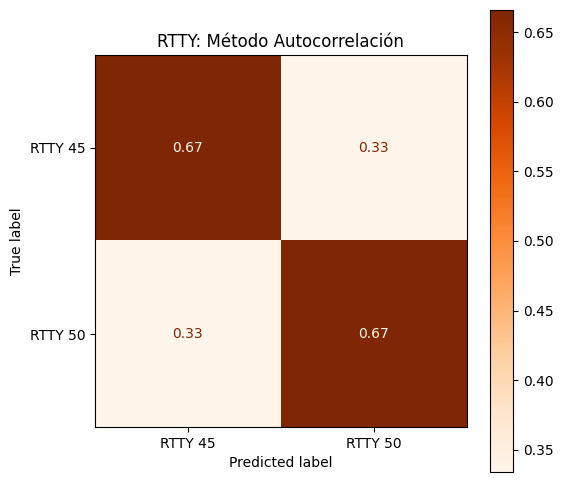

['C:\\inteligencia_en_red\\modelos\\modelo_micro_rtty_autocorr.joblib']

In [8]:
print("Entrenando Decisor RTTY (Método Autocorrelación)...")

clf_rtty_corr = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.5,
    gamma=0.5,
    reg_alpha=0.5,
    reg_lambda=2,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           
    early_stopping_rounds=100
)

clf_rtty_corr.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# --- EVALUACIÓN ---
y_pred = clf_rtty_corr.predict(X_test)
nombres = ['RTTY 45', 'RTTY 50']

print("\n--- REPORTE RTTY (AUTOCORRELACIÓN) ---")
print(classification_report(y_test, y_pred, target_names=nombres))

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=nombres, cmap='Oranges', normalize='true', values_format='.2f', ax=ax
)
plt.title("RTTY: Método Autocorrelación")
plt.show()

# GUARDAR
pkg = {
    'modelo': clf_rtty_corr, 
    'tipo': 'Micro-Especialista RTTY (Autocorrelación)',
    'requiere_autocorr': True # ¡Importante recordar esto para la inferencia!
}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_micro_rtty_autocorr.joblib')

## Comprobación de entradas de modelos

In [12]:
import joblib
import numpy as np

def comprobar_inputs_modelos(ruta_modelo_1, ruta_modelo_2):
    """
    Carga dos modelos .joblib y compara sus características esperadas.
    """
    print(f"--- COMPARANDO MODELOS ---")
    print(f"1: {ruta_modelo_1}")
    print(f"2: {ruta_modelo_2}")
    
    # 1. CARGAR
    try:
        pkg1 = joblib.load(ruta_modelo_1)
        pkg2 = joblib.load(ruta_modelo_2)
        
        # Extraer el modelo si está dentro de un diccionario (como tus paquetes)
        model1 = pkg1['modelo'] if isinstance(pkg1, dict) and 'modelo' in pkg1 else pkg1
        model2 = pkg2['modelo'] if isinstance(pkg2, dict) and 'modelo' in pkg2 else pkg2
        
    except Exception as e:
        print(f"❌ Error al cargar archivos: {e}")
        return

    # 2. OBTENER FEATURES DEL MODELO 1
    f1 = get_features(model1)
    # 3. OBTENER FEATURES DEL MODELO 2
    f2 = get_features(model2)

    # 4. COMPARAR
    print("\n--- RESULTADOS ---")
    
    # A) Comparar Cantidad
    if f1['n_features'] != f2['n_features']:
        print(f"❌ DIFERENTE NÚMERO DE COLUMNAS:")
        print(f"   Modelo 1 espera: {f1['n_features']}")
        print(f"   Modelo 2 espera: {f2['n_features']}")
        return # Si el número es distinto, ya no seguimos
    else:
        print(f"✅ Ambos esperan {f1['n_features']} columnas.")

    # B) Comparar Nombres (si existen)
    if f1['names'] is not None and f2['names'] is not None:
        # Convertimos a listas de Python para comparar fácil
        lista1 = list(f1['names'])
        lista2 = list(f2['names'])
        
        if lista1 == lista2:
            print("✅ Los nombres de las columnas coinciden EXACTAMENTE.")
        else:
            print("❌ LOS NOMBRES NO COINCIDEN:")
            # Buscamos las diferencias
            diff1 = set(lista1) - set(lista2)
            diff2 = set(lista2) - set(lista1)
            
            if diff1: print(f"   Modelo 1 tiene de más: {list(diff1)[:5]} ...")
            if diff2: print(f"   Modelo 2 tiene de más: {list(diff2)[:5]} ...")
            
            # Chequear orden
            if set(lista1) == set(lista2):
                print("   ⚠️ Tienen las mismas columnas pero en DIFERENTE ORDEN.")
    else:
        print("⚠️ Uno de los modelos no guardó los nombres de las columnas (solo se validó cantidad).")

def get_features(clf):
    """Extrae nombres y número de features según el tipo de modelo"""
    info = {'n_features': 0, 'names': None}
    
    # Caso XGBoost
    if hasattr(clf, 'feature_names_in_'):
        info['names'] = clf.feature_names_in_
        info['n_features'] = len(clf.feature_names_in_)
    elif hasattr(clf, 'n_features_in_'):
        info['n_features'] = clf.n_features_in_
        # A veces XGBoost guarda los nombres en el Booster interno
        try:
            info['names'] = clf.get_booster().feature_names
        except:
            pass
            
    # Caso Scikit-Learn / HistGradient
    elif hasattr(clf, 'n_features_in_'):
        info['n_features'] = clf.n_features_in_
        
    return info

# --- EJEMPLO DE USO ---
# Ajusta las rutas a tus archivos reales
ruta_A = r'C:/inteligencia_en_red/modelos/modelo_unificado_fft.joblib'
ruta_B = r'C:/inteligencia_en_red/modelos/modelo_micro_rtty_snr.joblib'

comprobar_inputs_modelos(ruta_A, ruta_B)

--- COMPARANDO MODELOS ---
1: C:/inteligencia_en_red/modelos/modelo_unificado_fft.joblib
2: C:/inteligencia_en_red/modelos/modelo_micro_rtty_snr.joblib

--- RESULTADOS ---
❌ DIFERENTE NÚMERO DE COLUMNAS:
   Modelo 1 espera: 2048
   Modelo 2 espera: 201


## Decisor Entre Am y Navtex y rtts

Cargando dataset...
Filtrando clases: ['am', 'navtex', 'rtty45_170', 'rtty50_170']...
Distribución de clases para este modelo:
target_label
Familia RTTY    19200
navtex           9600
am               9600
Name: count, dtype: int64
Generando Features (FFT Log + SNR)...
Clases codificadas: ['Familia RTTY' 'am' 'navtex']
Entrenando Decisor Intermedio (AM vs Navtex vs RTTYs)...
[0]	validation_0-mlogloss:1.07610	validation_1-mlogloss:1.07732
[100]	validation_0-mlogloss:0.40655	validation_1-mlogloss:0.45569
[200]	validation_0-mlogloss:0.27746	validation_1-mlogloss:0.35375
[300]	validation_0-mlogloss:0.21346	validation_1-mlogloss:0.31279
[400]	validation_0-mlogloss:0.17070	validation_1-mlogloss:0.28927
[500]	validation_0-mlogloss:0.13903	validation_1-mlogloss:0.27275
[600]	validation_0-mlogloss:0.11587	validation_1-mlogloss:0.26021
[700]	validation_0-mlogloss:0.09896	validation_1-mlogloss:0.25092
[800]	validation_0-mlogloss:0.08995	validation_1-mlogloss:0.24570
[900]	validation_0-mlogloss:0.

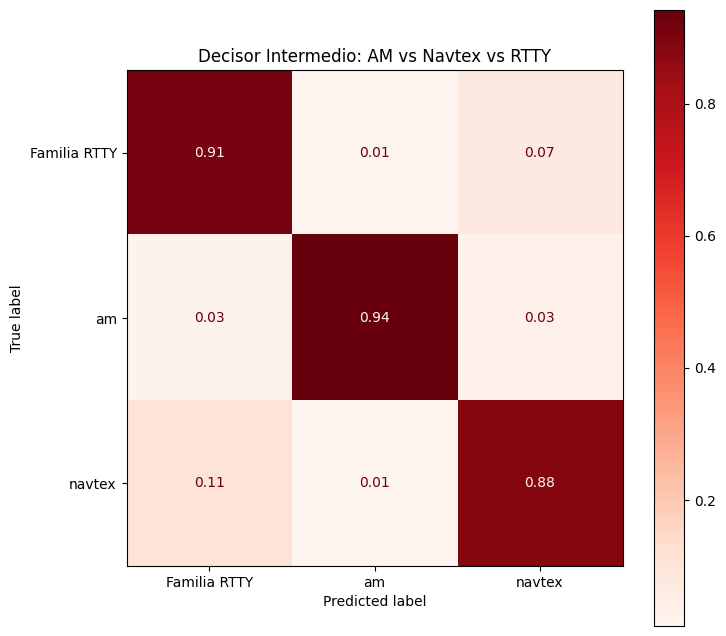

✅ Modelo Intermedio Guardado.


In [16]:
BASE_PATH = Path(r'C:/inteligencia_en_red')

# 1. CARGAR DATASET
print("Cargando dataset...")
df_full = pd.read_pickle(BASE_PATH / 'dataset_completo.pkl')

# 2. FILTRAR SOLO LAS CLASES DE ESTE NIVEL
clases_interes = ['am', 'navtex', 'rtty45_170', 'rtty50_170']
print(f"Filtrando clases: {clases_interes}...")

mask = df_full[' mode'].str.strip().isin(clases_interes)
df_resto = df_full[mask].copy()

# 3. DEFINIR LAS 3 SALIDAS (AGRUPANDO RTTY)
def agrupar_resto(modo):
    m = modo.strip().lower()
    if 'rtty' in m:
        return 'Familia RTTY' # Agrupamos 45 y 50 aquí
    return m # 'am' o 'navtex' se quedan igual

df_resto['target_label'] = df_resto[' mode'].apply(agrupar_resto)

print("Distribución de clases para este modelo:")
print(df_resto['target_label'].value_counts())

# 4. PREPARACIÓN DE FEATURES (FFT LOG + SNR)
print("Generando Features (FFT Log + SNR)...")

# A) SNR
snr_values = df_resto[' snr'].values.reshape(-1, 1)

# B) FFT Logarítmica (Ideal para distinguir AM de FSK)
signal_cols = [c for c in df_resto.columns if c.startswith('sample_')]
X_time = df_resto[signal_cols].values

# FFT
X_freq = np.abs(np.fft.fft(X_time, axis=1))
# Nos quedamos con la mitad y aplicamos Log
X_fft_log = np.log1p(X_freq[:, :2048])

# C) Fusión
X_final = np.hstack((snr_values, X_fft_log))

# 5. PREPARAR LABELS
le_resto = LabelEncoder()
y = le_resto.fit_transform(df_resto['target_label'])
print(f"Clases codificadas: {le_resto.classes_}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

# Pesos (AM y Navtex tienen menos muestras que la suma de RTTYs)
weights = compute_sample_weight('balanced', y_train)

# 6. ENTRENAR
print("Entrenando Decisor Intermedio (AM vs Navtex vs RTTYs)...")

clf_resto = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.4,
    gamma=1,
    reg_alpha=1,
    reg_lambda=5,
    objective='multi:softprob', # Multiclase (3 clases)
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    device='cuda',           
    early_stopping_rounds=50
)

clf_resto.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# 7. EVALUAR
y_pred = clf_resto.predict(X_test)
names = le_resto.inverse_transform(y_test)
preds = le_resto.inverse_transform(y_pred)

print("\n--- REPORTE RESTO ---")
print(classification_report(names, preds))

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    names, preds, 
    cmap='Reds', # Color rojo para este nivel
    normalize='true', 
    values_format='.2f', 
    ax=ax
)
plt.title("Decisor Intermedio: AM vs Navtex vs RTTY")
plt.show()

# 8. GUARDAR
pkg = {
    'modelo': clf_resto, 
    'encoder': le_resto, 
    'tipo': 'Decisor Intermedio (AM/Navtex/RTTY_Group)',
    'requiere_fft_log': True,
    'usa_snr': True
}
joblib.dump(pkg, BASE_PATH / 'modelos/modelo_decisor_resto.joblib')
print("✅ Modelo Intermedio Guardado.")

# Prueba arquitectura Cat A, Cat B y Resto

🏗️ Cargando tu arquitectura personalizada...
✅ Modelos cargados y listos.
Cargando datos...
Muestras de prueba: 34560
🚀 Ejecutando cascada...
⏱️ Tiempo: 29.21s
                precision    recall  f1-score   support

           fax       0.67      0.76      0.71      1920
           lsb       0.94      0.97      0.96      1920
           usb       0.93      0.98      0.95      1920
         morse       0.76      0.83      0.79      1920
     mt63_1000       0.64      0.90      0.75      1920
Familia Domino       0.80      0.71      0.75      1920
Familia Olivia       0.91      0.74      0.82      7680
   Familia PSK       0.87      0.83      0.85      5760
            am       0.83      0.81      0.82      1920
        navtex       0.82      0.89      0.86      1920
    rtty45_170       0.83      0.86      0.85      1920
    rtty50_170       0.84      0.86      0.85      1920

     micro avg       0.83      0.83      0.83     32640
     macro avg       0.82      0.85      0.83     3264

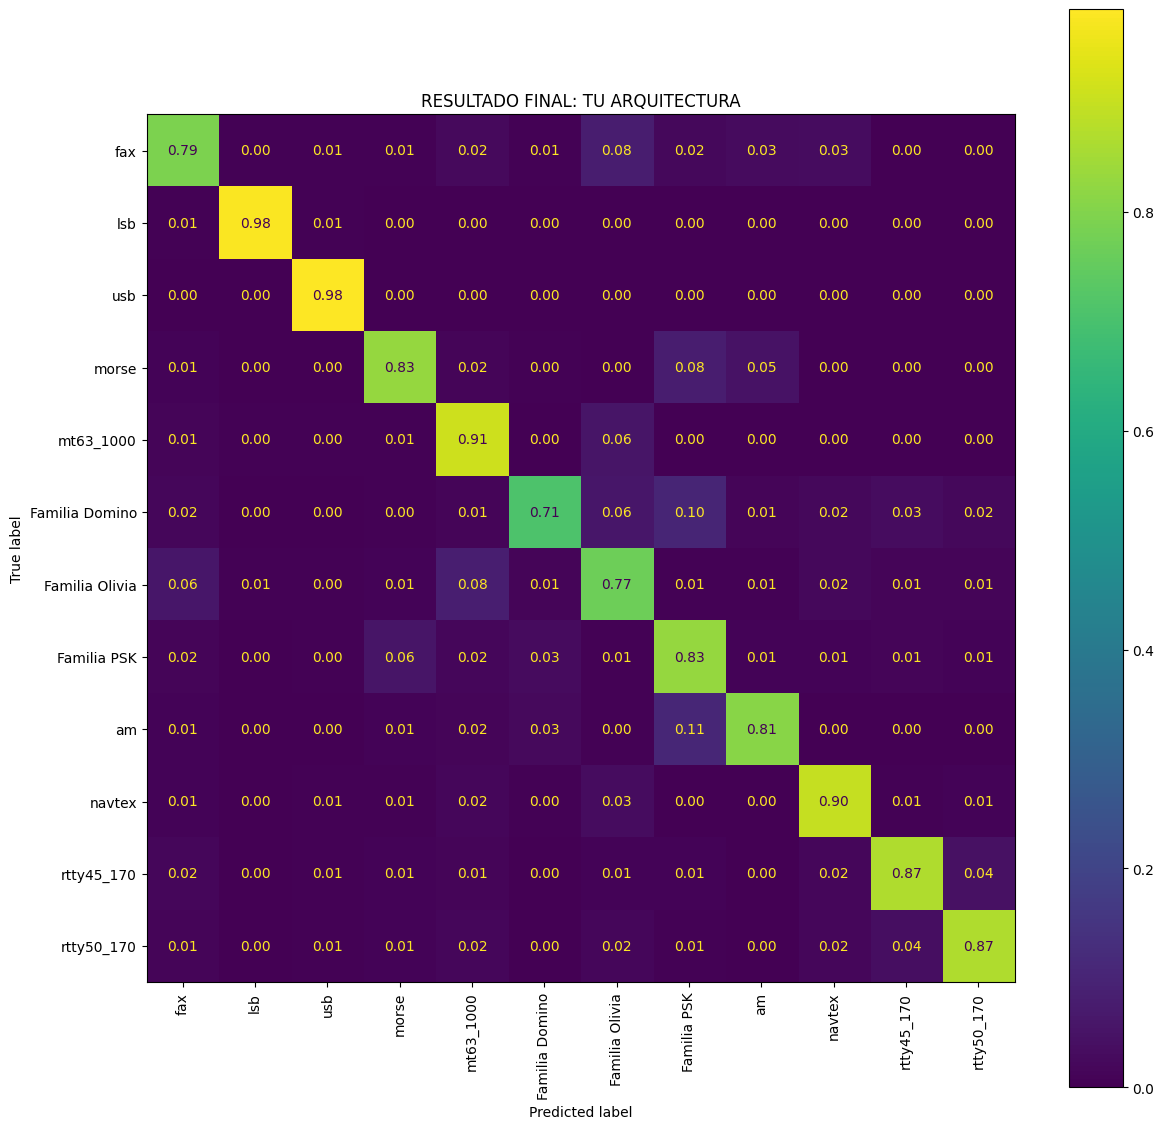

In [22]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# --- 1. CARGA DE MODELOS ---
BASE_PATH = Path(r'C:/inteligencia_en_red')
MODELOS_DIR = BASE_PATH / 'modelos'
DATA_FILE = BASE_PATH / 'dataset_completo.pkl'

print("🏗️ Cargando tu arquitectura personalizada...")

# 1. Portero (A vs B) -> Espera Raw + SNR
pkg_cat = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_categorias.joblib')
model_portero = pkg_cat['modelo']

# 2. Categoría A (Específico) -> Espera Raw + SNR
pkg_A = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_cat_A.joblib')
model_A = pkg_A['modelo']
le_A = pkg_A['encoder']

# 3. Categoría B (Familias + Resto) -> Espera FFT Log
pkg_B = joblib.load(MODELOS_DIR / 'modelo_unificado_fft.joblib') # Este es el que tiene "RESTO"
model_B = pkg_B['modelo']
le_B = pkg_B['encoder']

# 4. Decisor Resto (AM/Navtex/RTTY) -> Espera FFT Log + SNR
pkg_resto = joblib.load(MODELOS_DIR / 'modelo_decisor_resto.joblib')
model_resto = pkg_resto['modelo']
le_resto = pkg_resto['encoder']

# 5. Micro RTTY (45 vs 50) -> Espera Envelope + SNR
pkg_micro = joblib.load(MODELOS_DIR / 'modelo_micro_rtty_snr.joblib')
model_micro = pkg_micro['modelo']

print("✅ Modelos cargados y listos.")

# --- 2. PREPARAR DATOS DE TEST ---
print(f"Cargando datos...")
df_full = pd.read_pickle(DATA_FILE)

# Separar X e y
signal_cols = [c for c in df_full.columns if c.startswith('sample_')]
X_raw = df_full[signal_cols]
snr_col = df_full[' snr']
y_true = df_full[' mode']

# Split (Igual que en entrenamientos)
indices_train, indices_test = train_test_split(
    df_full.index, test_size=0.2, stratify=y_true, random_state=42
)

X_test_raw = X_raw.loc[indices_test]
snr_test = snr_col.loc[indices_test]
y_test = y_true.loc[indices_test]

print(f"Muestras de prueba: {len(X_test_raw)}")

# --- 3. FUNCIÓN DE CASCADA EXACTA ---
def ejecutar_cascada_final(X_in, snr_in):
    # 1. Preparación de matrices base
    X_np = X_in.values
    snr_np = snr_in.values.reshape(-1, 1)
    
    # Feature Set 1: Raw + SNR (4097 cols) -> Para Portero y Modelo A
    feats_raw_snr = np.hstack((snr_np, X_np))
    
    # Feature Set 2: FFT Log (2048 cols) -> Para Modelo B
    # Calculamos esto para todos de golpe por eficiencia
    freq = np.abs(np.fft.fft(X_np, axis=1))[:, :2048]
    feats_fft_log = np.log1p(freq)
    
    # Feature Set 3: FFT Log + SNR (2049 cols) -> Para Decisor Resto
    feats_resto = np.hstack((snr_np, feats_fft_log))
    
    # Array de resultados
    n = len(X_np)
    preds = np.array(["PENDIENTE"] * n, dtype=object)
    
    # ============================================================
    # NIVEL 1: PORTERO (A o B)
    # ============================================================
    # Asumimos: 1=Cat A, 0=Cat B (Según tu entrenamiento original)
    decisiones_portero = model_portero.predict(feats_raw_snr)
    
    idx_A = np.where(decisiones_portero == 1)[0]
    idx_B = np.where(decisiones_portero == 0)[0]
    
    # ============================================================
    # NIVEL 2 - RAMA A (Raw + SNR)
    # ============================================================
    if len(idx_A) > 0:
        p_num = model_A.predict(feats_raw_snr[idx_A])
        preds[idx_A] = le_A.inverse_transform(p_num)
        # Fin de la rama A (ya tenemos fax, lsb, etc.)

    # ============================================================
    # NIVEL 2 - RAMA B (FFT Log)
    # ============================================================
    if len(idx_B) > 0:
        # Predice: Olivia, PSK, Domino o RESTO
        p_num = model_B.predict(feats_fft_log[idx_B])
        p_nom = le_B.inverse_transform(p_num)
        preds[idx_B] = p_nom
        
        # ========================================================
        # NIVEL 3 - RAMA RESTO (Si B dijo 'RESTO')
        # ========================================================
        # 'RESTO (AM/RTTY/etc)' es la etiqueta exacta que pusimos en el paso anterior
        # Buscamos dentro de los índices de B, cuáles salieron Resto
        mask_es_resto = np.array([True if 'RESTO' in str(x) else False for x in p_nom])
        idx_global_resto = idx_B[mask_es_resto]
        
        if len(idx_global_resto) > 0:
            # Predice: am, navtex o Familia RTTY
            p_num_R = model_resto.predict(feats_resto[idx_global_resto])
            p_nom_R = le_resto.inverse_transform(p_num_R)
            preds[idx_global_resto] = p_nom_R
            
            # ====================================================
            # NIVEL 4 - RAMA MICRO RTTY (Si Resto dijo 'Familia RTTY')
            # ====================================================
            mask_es_rtty = (p_nom_R == 'Familia RTTY')
            idx_global_rtty = idx_global_resto[mask_es_rtty]
            
            if len(idx_global_rtty) > 0:
                # Necesitamos calcular Envelope FFT SOLO para estos pocos
                X_sub = X_np[idx_global_rtty]
                snr_sub = snr_np[idx_global_rtty]
                
                # Cálculo Envelope
                mid = 2048
                x_r = X_sub[:, :mid]
                x_i = X_sub[:, mid:]
                x_mag = np.sqrt(x_r**2 + x_i**2)
                x_mag_cent = x_mag - np.mean(x_mag, axis=1, keepdims=True)
                x_env = np.abs(np.fft.fft(x_mag_cent, axis=1))[:, :200]
                
                # Feature Set 4: SNR + Envelope (201 cols)
                feats_micro = np.hstack((snr_sub, x_env))
                
                p_num_M = model_micro.predict(feats_micro)
                # 0=45, 1=50
                nombres_rtty = np.where(p_num_M == 1, 'rtty50_170', 'rtty45_170')
                preds[idx_global_rtty] = nombres_rtty

    return preds

# --- 4. EJECUTAR Y MEDIR ---
print("🚀 Ejecutando cascada...")
start = time.time()
y_pred_final = ejecutar_cascada_final(X_test_raw, snr_test)
end = time.time()
print(f"⏱️ Tiempo: {end - start:.2f}s")

# --- 5. NORMALIZAR PARA LA GRÁFICA ---
# Convertimos las etiquetas reales al formato final que esperamos
def normalizar(t):
    t = t.strip().lower()
    if 'olivia' in t: return 'Familia Olivia'
    if 'psk' in t or 'qpsk' in t: return 'Familia PSK'
    if 'domino' in t: return 'Familia Domino'
    return t # El resto deben coincidir exacto (fax, am, rtty45...)

y_test_norm = y_test.apply(normalizar)
y_pred_norm = [normalizar(p) for p in y_pred_final]

# Orden lógico para la matriz
labels = [
    'fax', 'lsb', 'usb', 'morse', 'mt63_1000', # A
    'Familia Domino', 'Familia Olivia', 'Familia PSK', # B Digitales
    'am', 'navtex', 'rtty45_170', 'rtty50_170' # B Resto
]

print(classification_report(y_test_norm, y_pred_norm, labels=labels))

fig, ax = plt.subplots(figsize=(14, 14))
ConfusionMatrixDisplay.from_predictions(
    y_test_norm, y_pred_norm, labels=labels,
    cmap='viridis', normalize='true', values_format='.2f', xticks_rotation='vertical', ax=ax
)
plt.title("RESULTADO FINAL: TU ARQUITECTURA")
plt.show()

# MODELO FINAL

🏗️ CARGANDO SISTEMA FINAL (INTEGRACIÓN EQUIPO)...
✅ Modelos cargados.
Cargando datos...
🚀 Ejecutando CASCADA FINAL...
⏱️ Tiempo: 14.99s
               precision    recall  f1-score   support

           am       0.83      0.81      0.82      1920
   dominoex11       0.80      0.71      0.75      1920
          fax       0.67      0.76      0.71      1920
          lsb       0.94      0.97      0.96      1920
        morse       0.76      0.83      0.79      1920
    mt63_1000       0.64      0.90      0.75      1920
       navtex       0.82      0.89      0.86      1920
olivia16_1000       0.80      0.67      0.73      1920
 olivia16_500       0.91      0.81      0.86      1920
olivia32_1000       0.93      0.56      0.70      1920
  olivia8_250       0.84      0.77      0.80      1920
        psk31       0.79      0.71      0.75      1920
        psk63       0.83      0.70      0.76      1920
       qpsk31       0.69      0.76      0.73      1920
  rtty100_850       0.82      0.96    

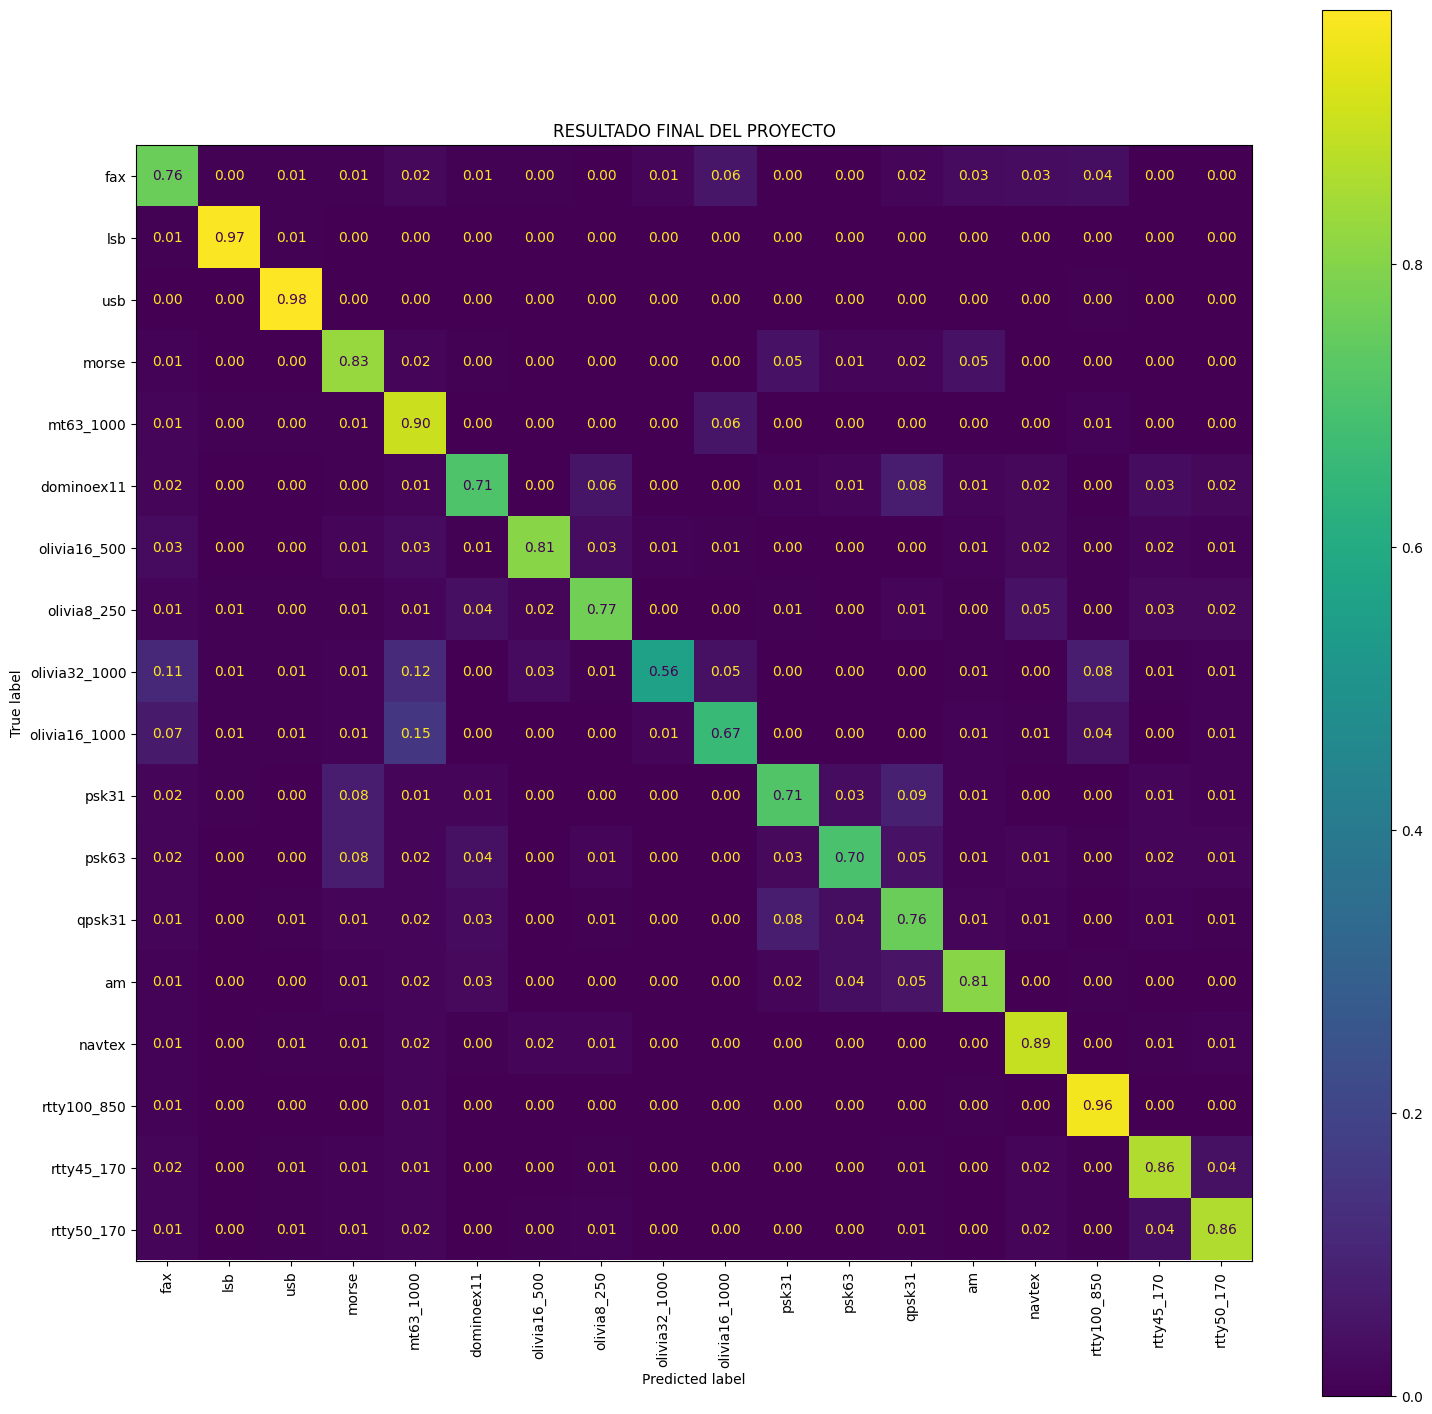

In [29]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# --- 1. CONFIGURACIÓN ---
BASE_PATH = Path(r'C:/inteligencia_en_red')
MODELOS_DIR = BASE_PATH / 'modelos'
DATA_FILE = BASE_PATH / 'dataset_completo.pkl'

print("🏗️ CARGANDO SISTEMA FINAL (INTEGRACIÓN EQUIPO)...")

# --- CARGA DE MODELOS ---
# 1. Portero
pkg_port = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_categorias.joblib')
model_portero = pkg_port['modelo']

# 2. Rama A (Raw)
pkg_A = joblib.load(MODELOS_DIR / 'modelo_xgboost_local_cat_A.joblib')
model_A = pkg_A['modelo']
le_A = pkg_A['encoder']

# 3. Rama B (Distribuidor - FFT Log Mitad)
pkg_B = joblib.load(MODELOS_DIR / 'modelo_unificado_fft.joblib')
model_B = pkg_B['modelo']
le_B = pkg_B['encoder']

# 4. Especialista Olivia (FFT Log COMPLETA - 4096 cols)
model_olivia = joblib.load(MODELOS_DIR / 'entre_olivia_modelo.joblib')
le_olivia = joblib.load(MODELOS_DIR / 'entre_olivia_encoder.joblib')

# 5. Especialista PSK (Envelope FFT)
model_psk = joblib.load(MODELOS_DIR / 'entre_psk_modelo.joblib')
le_psk = joblib.load(MODELOS_DIR / 'entre_psk_encoder.joblib')

# 6. Decisor Resto (FFT Log Mitad + SNR)
pkg_resto = joblib.load(MODELOS_DIR / 'modelo_decisor_resto.joblib')
model_resto = pkg_resto['modelo']
le_resto = pkg_resto['encoder']

# 7. Micro RTTY (Envelope FFT + SNR)
pkg_micro_rtty = joblib.load(MODELOS_DIR / 'modelo_micro_rtty_snr.joblib')
model_micro_rtty = pkg_micro_rtty['modelo']

print("✅ Modelos cargados.")

# --- 2. DATOS ---
print(f"Cargando datos...")
df_full = pd.read_pickle(DATA_FILE)

signal_cols = [c for c in df_full.columns if c.startswith('sample_')]
X_raw = df_full[signal_cols]
snr_col = df_full[' snr']
y_true = df_full[' mode']

indices_train, indices_test = train_test_split(
    df_full.index, test_size=0.2, stratify=y_true, random_state=42
)

X_test_raw = X_raw.loc[indices_test]
snr_test = snr_col.loc[indices_test]
y_test = y_true.loc[indices_test]

# --- 3. FUNCIONES DE PROCESADO ---

def calc_fft_log_b(X_raw):
    # Para Modelo B (Distribuidor): Usa la mitad (2048)
    freq = np.abs(np.fft.fft(X_raw, axis=1))[:, :2048]
    return np.log1p(freq)

def calc_fft_log_olivia(X_raw):
    # Para Modelo Olivia: Usa FFT COMPLETA (4096) + Epsilon
    # Tal como indicaste: np.log(np.abs(np.fft.fft(signals)) + 1e-127)
    N = 2048
    x_r = X_raw[:, :N]
    x_i = X_raw[:, N:2*N]
    freq = np.abs(np.fft.fft(x_r + 1j * x_i, axis=1))
    return np.log(freq + 1e-127)

def calc_envelope_fft_psk(X_raw):
    # Para Modelo PSK: Envelope
    # Asumimos que el compañero usó la mitad (2048) o un recorte.
    # Si da error, prueba a cambiar el slice final.
    N = 2048
    x_r = X_raw[:, :N]
    x_i = X_raw[:, N:2*N]
    x_mag = np.sqrt(x_r**2 + x_i**2)
    x_mag_cent = x_mag - np.mean(x_mag, axis=1, keepdims=True)
    return x_mag_cent

def calc_envelope_fft_rtty(X_raw):
    # Para RTTY: Envelope FFT recortada (bajas frecuencias)
    mid = X_raw.shape[1] // 2
    x_r = X_raw[:, :mid]
    x_i = X_raw[:, mid:]
    x_mag = np.sqrt(x_r**2 + x_i**2)
    x_mag_cent = x_mag - np.mean(x_mag, axis=1, keepdims=True)
    x_env = np.abs(np.fft.fft(x_mag_cent, axis=1))[:, :200]
    return x_env

# --- 4. CASCADA FINAL ---

def ejecutar_sistema_final(X_in, snr_in):
    X_np = X_in.values
    snr_np = snr_in.values.reshape(-1, 1)
    X_con_snr = np.hstack((snr_np, X_np)) 
    
    preds = np.array(["PENDIENTE"] * len(X_np), dtype=object)
    
    # NIVEL 1: PORTERO
    decisiones_portero = model_portero.predict(X_con_snr)
    idx_A = np.where(decisiones_portero == 1)[0]
    idx_B = np.where(decisiones_portero == 0)[0]
    
    # NIVEL 2-A: RAW
    if len(idx_A) > 0:
        p_num = model_A.predict(X_con_snr[idx_A])
        preds[idx_A] = le_A.inverse_transform(p_num)

    # NIVEL 2-B: DIGITALES (Distribuidor)
    if len(idx_B) > 0:
        X_fft_log_B = calc_fft_log_b(X_np[idx_B])
        p_num_B = model_B.predict(X_fft_log_B)
        p_nom_B = le_B.inverse_transform(p_num_B)
        preds[idx_B] = p_nom_B
        
        # --- RAMA OLIVIA (FFT COMPLETA) ---
        mask_olivia = (p_nom_B == 'Familia Olivia')
        idx_global_olivia = idx_B[mask_olivia]
        if len(idx_global_olivia) > 0:
            feats_olivia = calc_fft_log_olivia(X_np[idx_global_olivia])
            p_num = model_olivia.predict(feats_olivia)
            preds[idx_global_olivia] = le_olivia.inverse_transform(p_num)

        # --- RAMA PSK (ENVELOPE FFT) ---
        mask_psk = (p_nom_B == 'Familia PSK')
        idx_global_psk = idx_B[mask_psk]
        if len(idx_global_psk) > 0:
            feats_psk = calc_envelope_fft_psk(X_np[idx_global_psk])
            p_num = model_psk.predict(feats_psk)
            preds[idx_global_psk] = le_psk.inverse_transform(p_num)

        # --- RAMA DOMINO ---
        mask_domino = (p_nom_B == 'Familia Domino')
        if np.any(mask_domino):
            preds[idx_B[mask_domino]] = 'dominoex11'

        # --- RAMA RESTO ---
        mask_resto = np.char.find(p_nom_B.astype(str), 'RESTO') >= 0
        idx_global_resto = idx_B[mask_resto]
        
        if len(idx_global_resto) > 0:
            X_fft_resto = calc_fft_log_b(X_np[idx_global_resto])
            feats_resto = np.hstack((snr_np[idx_global_resto], X_fft_resto))
            
            p_num_R = model_resto.predict(feats_resto)
            p_nom_R = le_resto.inverse_transform(p_num_R)
            preds[idx_global_resto] = p_nom_R
            
            # --- MICRO RTTY ---
            mask_rtty = (p_nom_R == 'Familia RTTY')
            idx_global_rtty = idx_global_resto[mask_rtty]
            
            if len(idx_global_rtty) > 0:
                x_env = calc_envelope_fft_rtty(X_np[idx_global_rtty])
                feats_rtty = np.hstack((snr_np[idx_global_rtty], x_env))
                
                p_num_M = model_micro_rtty.predict(feats_rtty)
                p_nom_M = np.where(p_num_M == 1, 'rtty50_170', 'rtty45_170')
                preds[idx_global_rtty] = p_nom_M

    return preds

# --- 5. EJECUCIÓN ---
print("🚀 Ejecutando CASCADA FINAL...")
start = time.time()
y_pred_final = ejecutar_sistema_final(X_test_raw, snr_test)
end = time.time()
print(f"⏱️ Tiempo: {end - start:.2f}s")

# --- 6. EVALUACIÓN ---
def normalizar(t):
    t = t.strip().lower()
    if 'domino' in t and 'familia' in t: return 'dominoex11'
    return t

y_test_norm = y_test.apply(normalizar)
y_pred_norm = [normalizar(p) for p in y_pred_final]

labels = [
    'fax', 'lsb', 'usb', 'morse', 'mt63_1000',
    'dominoex11',
    'olivia16_500', 'olivia8_250', 'olivia32_1000', 'olivia16_1000', 
    'psk31', 'psk63', 'qpsk31', 
    'am', 'navtex', 'rtty100_850', 'rtty45_170', 'rtty50_170'
]

print(classification_report(y_test_norm, y_pred_norm))

fig, ax = plt.subplots(figsize=(18, 18))
ConfusionMatrixDisplay.from_predictions(
    y_test_norm, y_pred_norm, labels=labels,
    cmap='viridis', normalize='true', values_format='.2f', xticks_rotation='vertical', ax=ax
)
plt.title("RESULTADO FINAL DEL PROYECTO")
plt.show()